In [1]:
from music21 import converter, note, stream
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def read_musicxml_and_normalize(path):
    """
    Reads a MusicXML file and returns normalized time and pitch data.
    parameter:
    - path: the path or directory of the MusicXML file.
    return value:
    - A dictionary containing music data, with keys being relative paths to files and values being dictionaries containing normalized time and pitch.
    """
    music_data = {}
    
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('.musicxml'):
                file_path = os.path.join(dirpath, filename)
                relative_path = os.path.relpath(file_path, path)
                
                score = converter.parse(file_path)
                
                pitches = []
                times = []
                current_time = 0.0
                
                for part in score.parts:
                    for measure in part.getElementsByClass('Measure'):
                        for note in measure.notes:
                            if note.isNote:
                                pitches.append(note.pitch.midi)
                                times.append(current_time)
                                current_time += note.duration.quarterLength
                
                total_time = max(times) if times else 1
                if total_time > 0:
                    normalized_times = [t / total_time for t in times]
                    music_data[relative_path] = {"pitches": pitches, "times": normalized_times}
                else:
                    print(f"Warning: '{relative_path}' contains no notes.")
                
                # music_data[relative_path] = {"pitches": pitches, "times": normalized_times}
    
    return music_data

In [3]:
def plot_pitch_contours(music_data, title="Normalized Time Pitch Contour"):
    """
    Plots the pitch contour of given musical data.
    parameters:
    - music_data: A dictionary containing the music data to plot.
    - title
    """
    plt.figure(figsize=(30, 10))
    
    for key, data in music_data.items():
        plt.plot(data["times"], data["pitches"], linestyle='-', label=key)
    
    plt.title(title)
    plt.xlabel('Normalized Time')
    plt.ylabel('Pitch (MIDI Note Number)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show() 

def plot_average_pitch_contours(music_data, title="Normalized Average Time Pitch Contour"):
    """
    Plots the average pitch profile of given music data.
    parameters:
    - music_data: A dictionary containing the music data to plot.
    - title
    """
    # Combine pitch data for all tracks into one list
    all_pitches = [data['pitches'] for data in music_data.values()]
    all_times = [data['times'] for data in music_data.values()]

    # Align all time and pitch data to the same timeline
    # Here you need to create a timeline that is common to all tracks
    # Assume that all tracks are already processed with the same normalized time length
    max_time_points = max(len(times) for times in all_times)
    common_time_line = np.linspace(0, 1, max_time_points)

    pitch_values_at_common_times = np.zeros((len(all_pitches), max_time_points))

    # nterpolate 
    for i, (times, pitches) in enumerate(zip(all_times, all_pitches)):
        pitch_values_at_common_times[i] = np.interp(common_time_line, times, pitches)

    # Calculate the average pitch at each time point on a universal timeline
    average_pitches = np.mean(pitch_values_at_common_times, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(common_time_line, average_pitches, label="Average Pitch Contour")
    plt.title(title)
    plt.xlabel('Normalized Time')
    plt.ylabel('Pitch (MIDI Note Number)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_cdf(music_data, title="CDF of Pitch Frequencies"):
    """
    plot the pitch's CDF。

    parameters:
    - music_data: A dictionary containing normalized time and pitch data for each piece.
    - title

    No return value, draw CDF graph directly.
    """
    # Summarize the pitches of all works into a list
    all_pitches = [pitch for data in music_data.values() for pitch in data['pitches']]
    
    # calculate the pdf
    values, base = np.histogram(all_pitches, bins=range(min(all_pitches), max(all_pitches) + 1), density=True)
    cumulative = np.cumsum(values)

    plt.figure(figsize=(10, 7))
    plt.plot(base[:-1], cumulative, c='blue')
    plt.title(title)
    plt.xlabel('Pitch (MIDI Note Number)')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [4]:
def plot_all_average_pitch_contours(baroque_musician_data, title="Normalized Average Time Pitch Contour"):
    """
    Plot the average pitch profile of multiple musicians.
    parameter:
    - baroque_musician_data: A dictionary whose keys are musician names and whose values ​​are the corresponding dictionary of music data.
    - title: The title of the chart.
    """
    plt.figure(figsize=(12, 6))
    
    for musician, music_data in baroque_musician_data.items():
        all_pitches = [data['pitches'] for data in music_data.values()]
        all_times = [data['times'] for data in music_data.values()]
        max_time_points = max(len(times) for times in all_times)
        common_time_line = np.linspace(0, 1, max_time_points)
        pitch_values_at_common_times = np.zeros((len(all_pitches), max_time_points))
        
        for i, (times, pitches) in enumerate(zip(all_times, all_pitches)):
            pitch_values_at_common_times[i] = np.interp(common_time_line, times, pitches)
        
        average_pitches = np.mean(pitch_values_at_common_times, axis=0)
        
        plt.plot(common_time_line, average_pitches, label=f"{musician} Average Pitch Contour")
    
    plt.title(title)
    plt.xlabel('Normalized Time')
    plt.ylabel('Pitch (MIDI Note Number)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_musician_contours_for_era(musician_paths, era_title):
    musician_data = {}
    for musician, path in musician_paths.items():
        music_data = read_musicxml_and_normalize(path)
        musician_data[musician] = music_data
    plot_all_average_pitch_contours(musician_data, f"Normalized Time Pitch Contour for {era_title} Musicians")

Main genres in the history of Western classical music and corresponding composers:

Baroque Period (Approx. 1600-1750):

Bach: A representative figure of the Baroque period, renowned for his polyphonic music.
Classical Period (Approx. 1750-1820):

Haydn and Mozart: Core figures of Classical music, known for their clear forms and harmonic structures.
Beethoven: His works transitioned from Classicism to Romanticism, especially his later pieces.
Romantic Period (Approx. 1820-1910):

Chopin, Liszt, Schumann, Brahms: Known for expressing personal emotions and musical innovations.
Tchaikovsky, Rachmaninoff: Russian Romantic composers, famous for their rich melodies and deep emotional music.
Schubert: An early Romantic figure, known for his songs and piano music.
Impressionist Period (Approx. 1875-1925):

Debussy: A pioneer of Impressionist music, emphasizing timbre and bold harmonic innovations.
20th Century and Modern Music:

Prokofiev and Ravel: Their music often includes modernist traits, such as extended harmonies and rhythmic complexity.
Scriabin: Innovative harmonic language and elements of mysticism.
Balakirev and Glinka: Important figures in Russian nationalism in music.

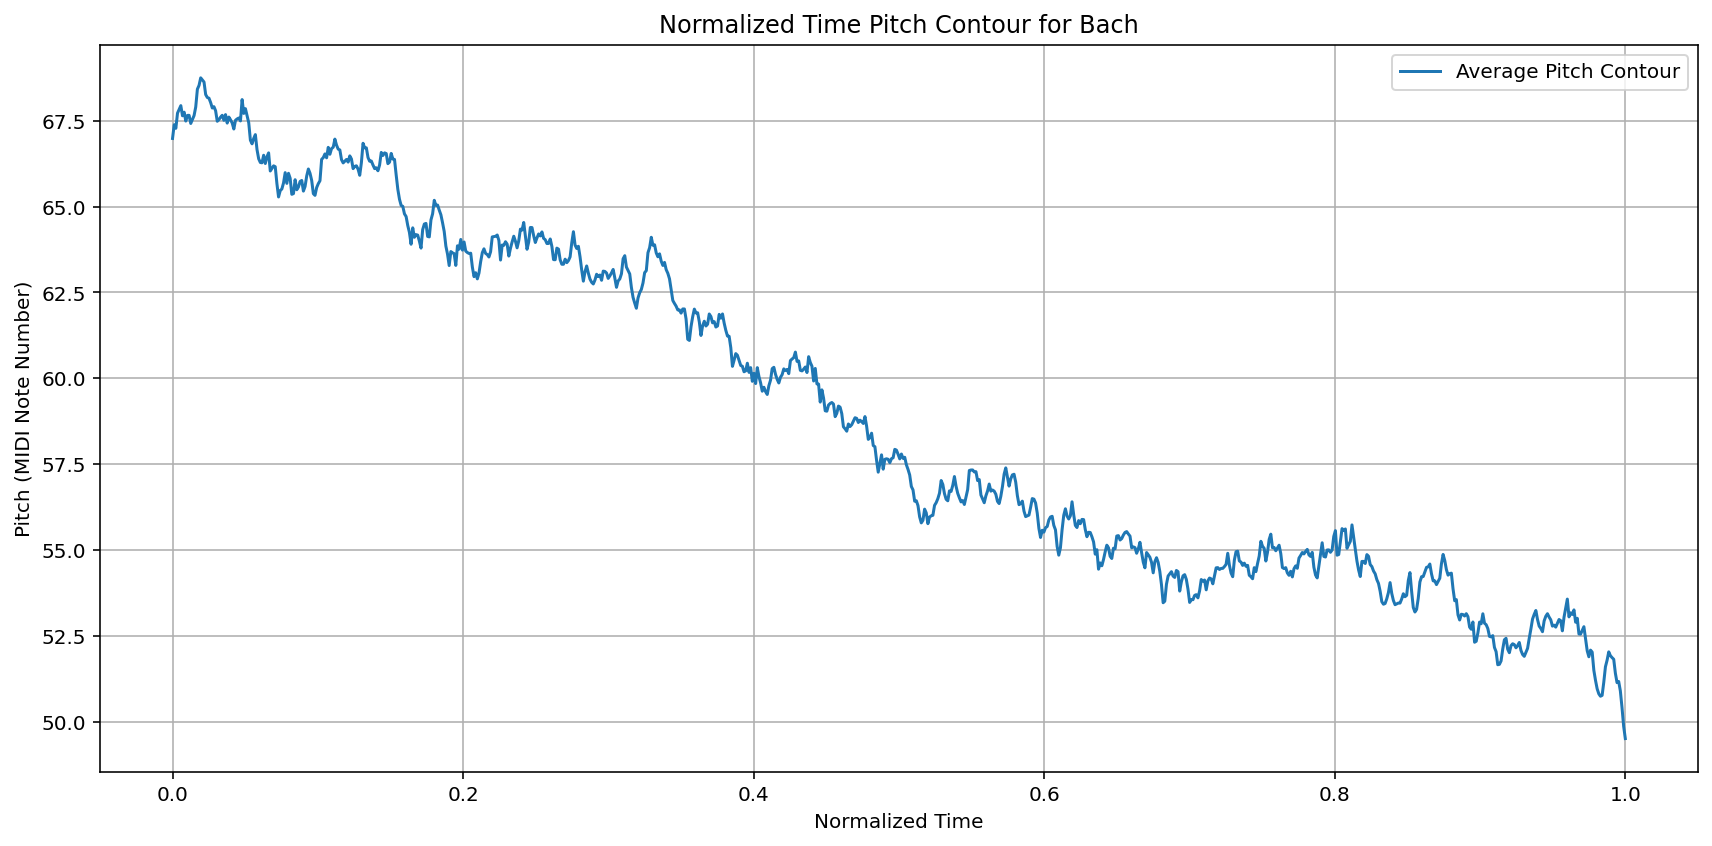

In [6]:
# 1. **Baroque** (1600-1750):
#    - **Bach**: A representative figure of the Baroque period, famous for his polyphonic music.

Baroque_musician_paths = {
    'Bach':'./Bach/',
    }

for musician, path in Baroque_musician_paths.items():
    music_data = read_musicxml_and_normalize(path)
    title = f"Normalized Time Pitch Contour for {musician}"
    # plot_pitch_contours(music_data, title)
    plot_average_pitch_contours(music_data, title)
    # plot_cdf(music_data)

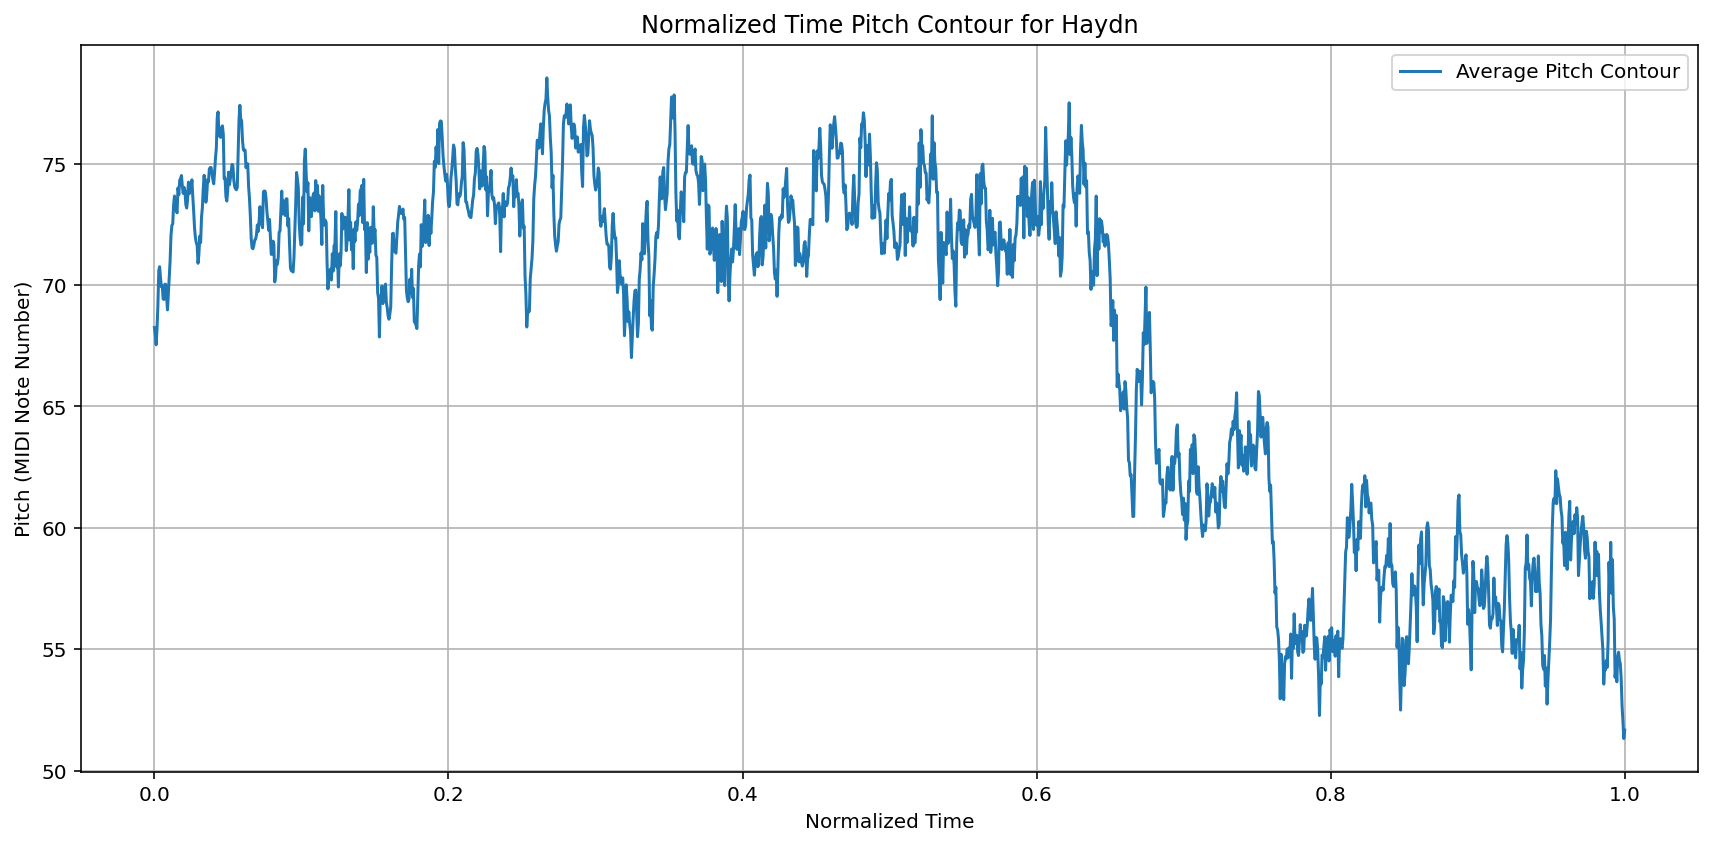

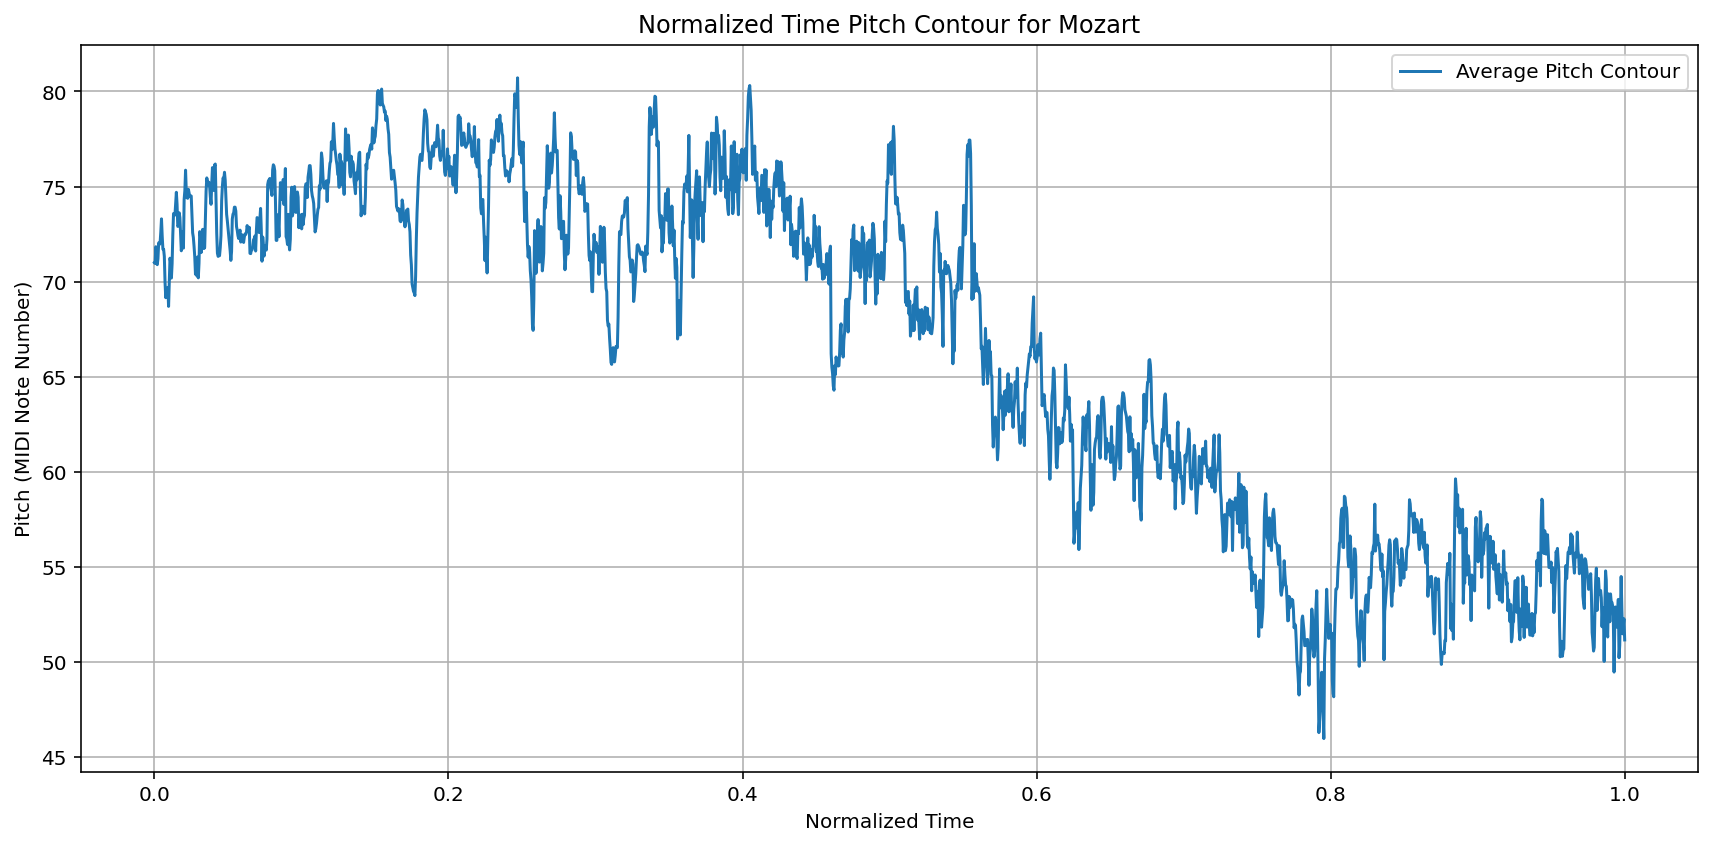

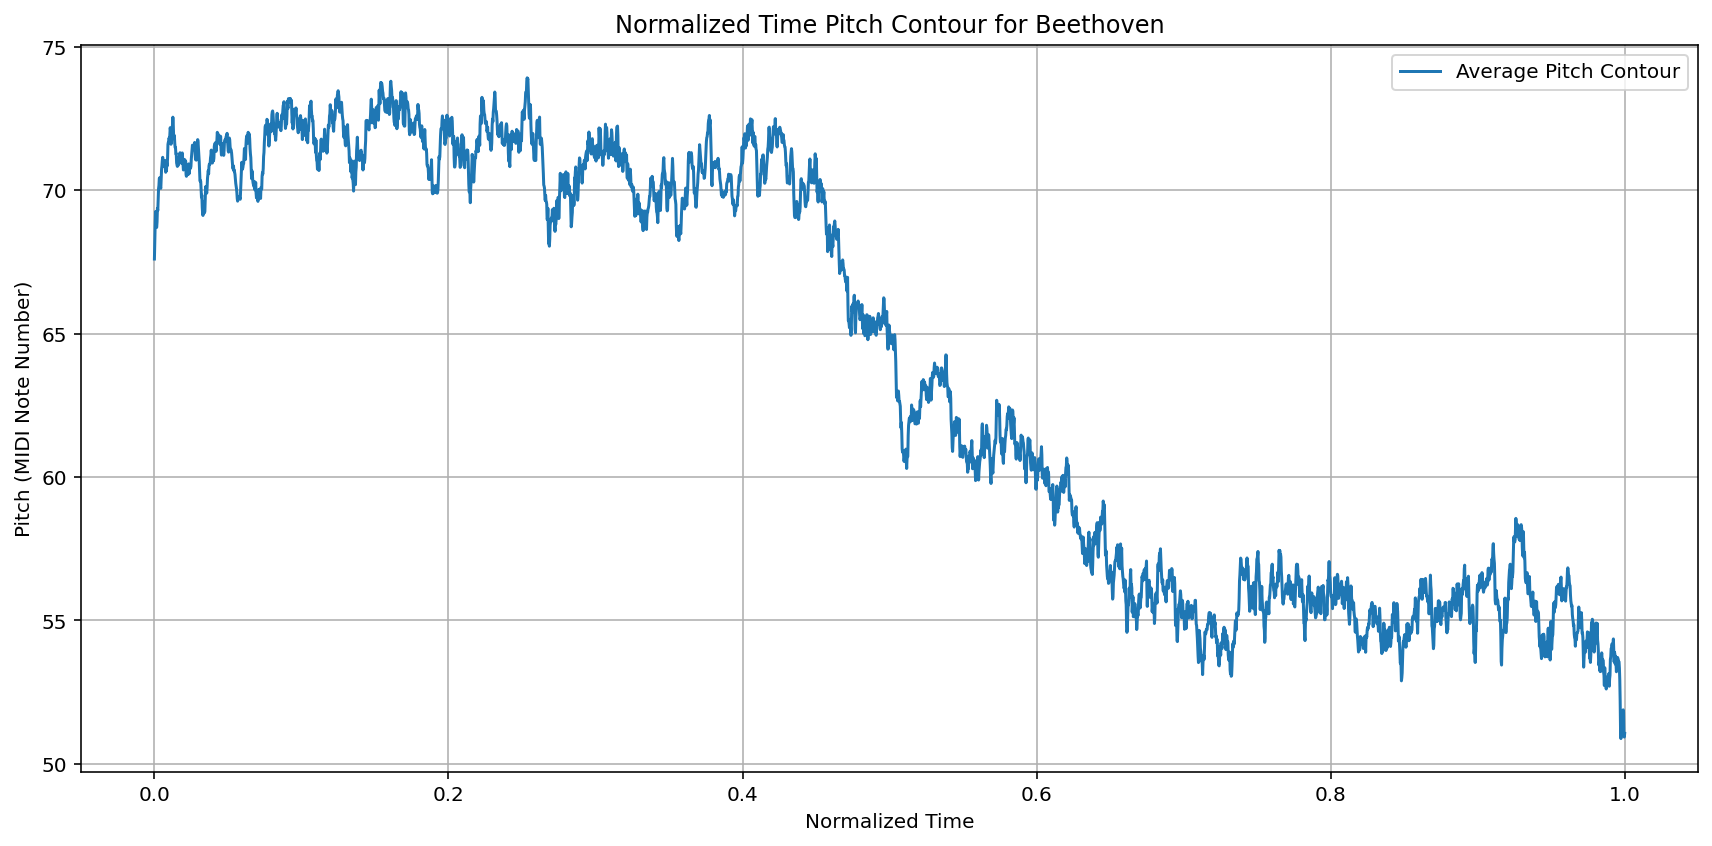

In [7]:
# 2.1 **Classical** (around1750-1820):
#    - **Haydn** 和 **Mozart**: Central figures in classical music, known for its clear forms and harmonious structures.
#    - **Beethoven**: His work transitioned from Classicism to Romanticism, especially his later works.

Classical_musician_paths = {
    'Haydn':'./Haydn/', 
    'Mozart':'./Mozart/',  
    'Beethoven':'./Beethoven/'
    }

for musician, path in Classical_musician_paths.items():
    music_data = read_musicxml_and_normalize(path)
    title = f"Normalized Time Pitch Contour for {musician}"
    # plot_pitch_contours(music_data, title)
    plot_average_pitch_contours(music_data, title)
    # plot_cdf(music_data)

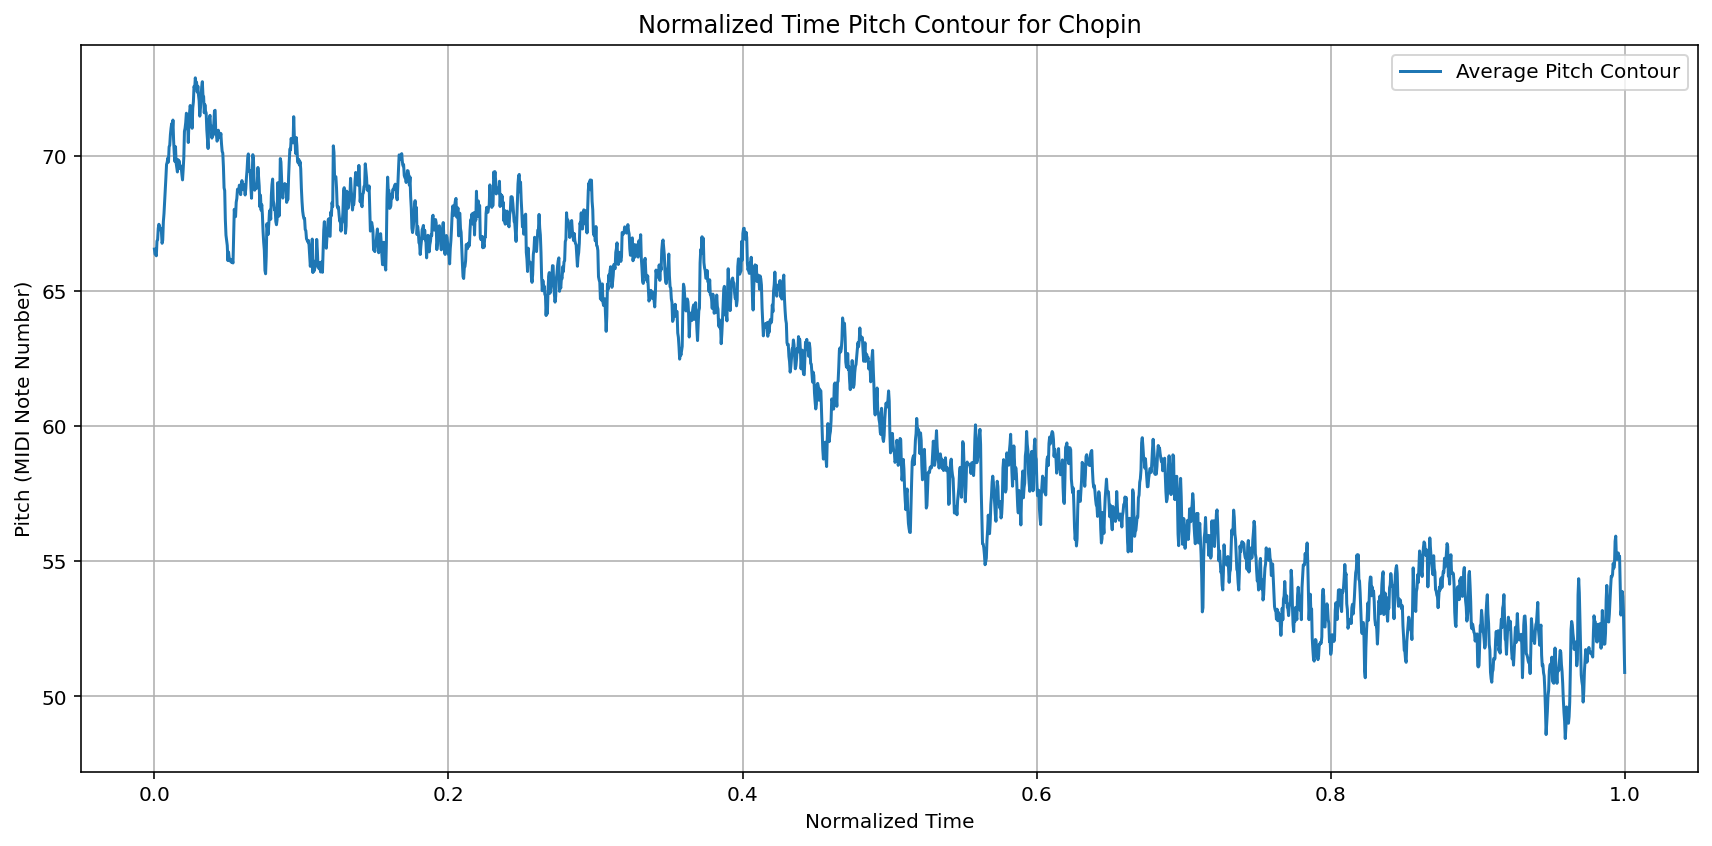

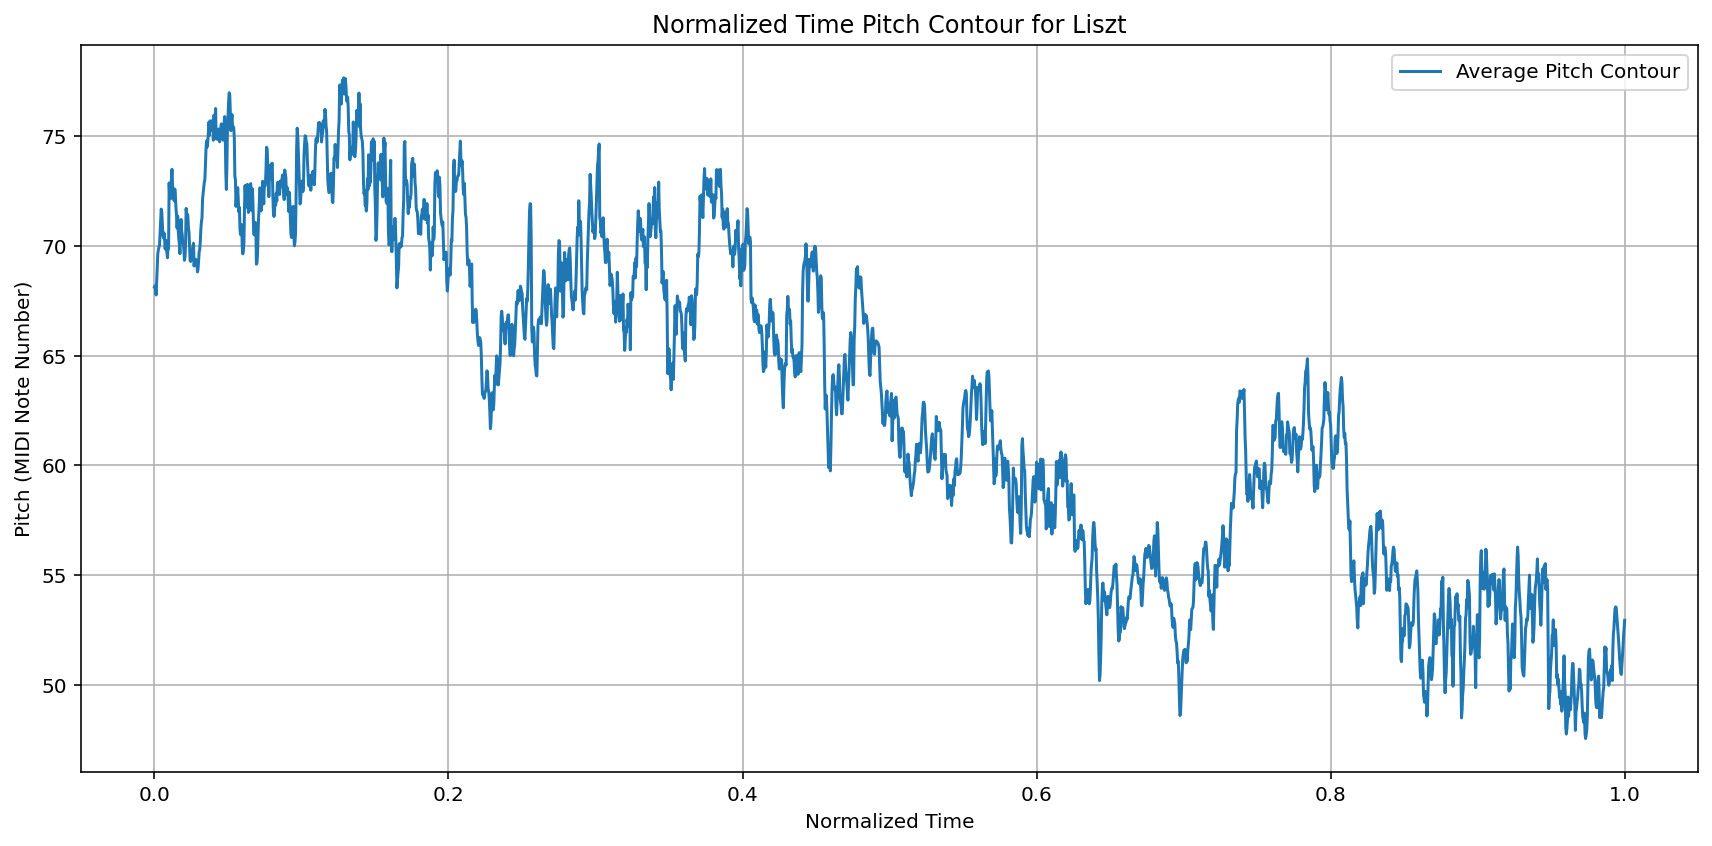

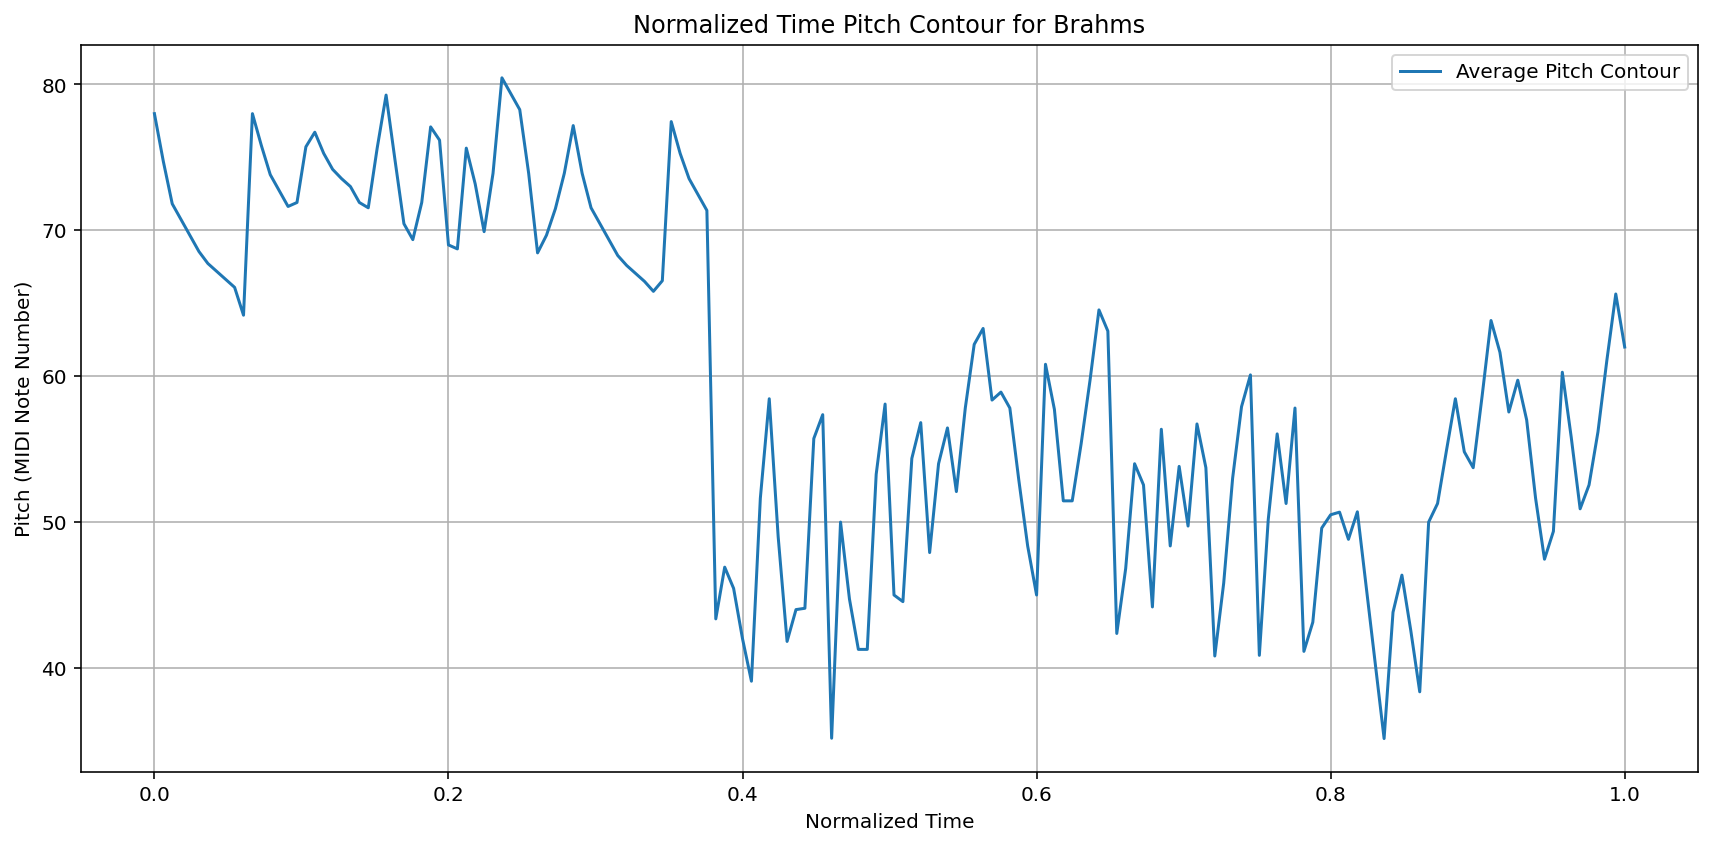

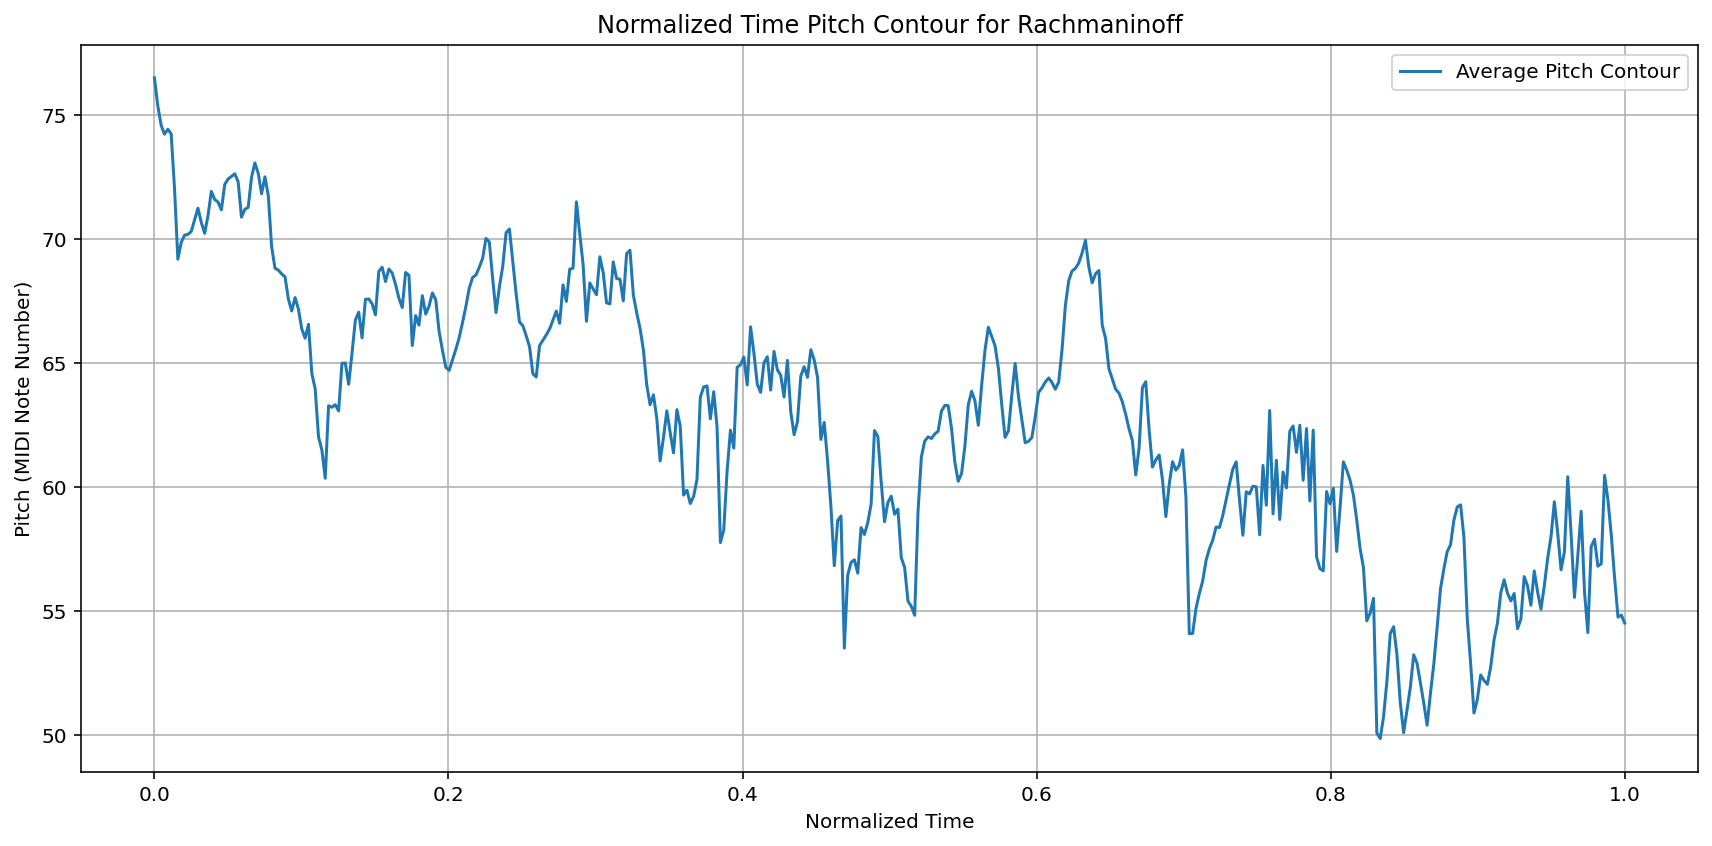

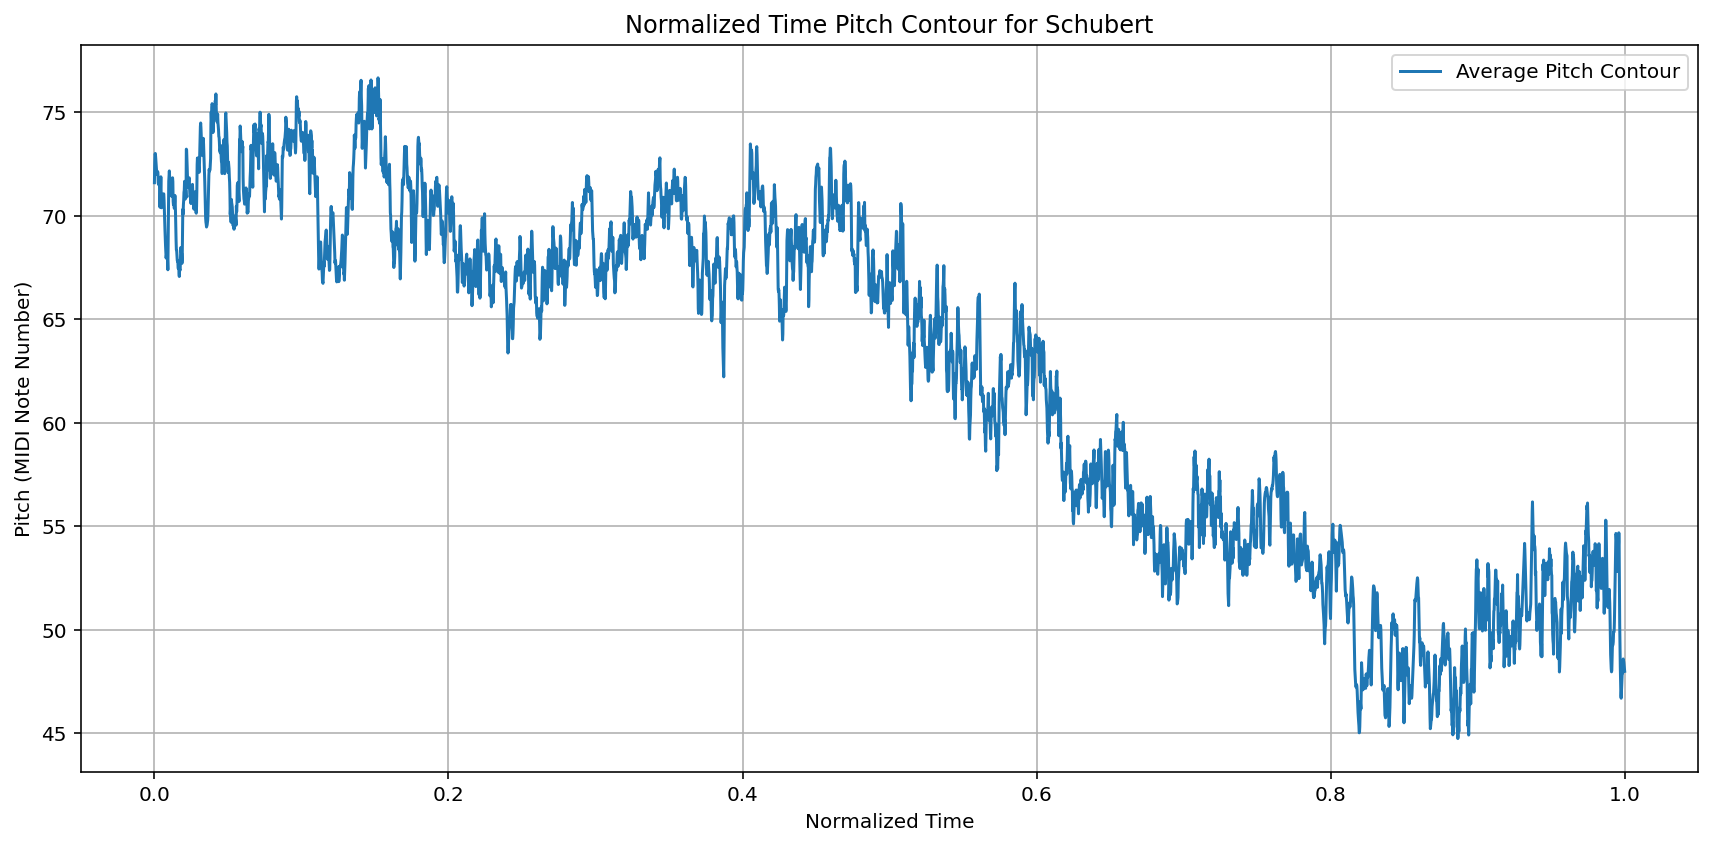

In [8]:
# 3. **Romantic** (around1820-1910):
#  Chopin, Liszt, Schumann, Brahms: Known for expressing personal emotions and musical innovation
#  Tchaikovsky, Rachmaninoff: Russian Romantic composer known for his richly melodic and deeply emotional music.
#  Schubert: Representative of early Romanticism, famous for his songs and piano music

Romantic_musician_paths = {
    'Chopin':'./Chopin/',
    'Liszt':'./Liszt/',
    # 'Schumann':'./Schumann/', # There is a problem with some data
    'Brahms':'./Brahms',
    # 'Tchaikovsky':'./Tchaikovsky/', # There is a problem with some data
    'Rachmaninoff':'./Rachmaninoff/',
    'Schubert':'./Schubert/'
    }

for musician, path in Romantic_musician_paths.items():
    music_data = read_musicxml_and_normalize(path)
    title = f"Normalized Time Pitch Contour for {musician}"
    # plot_pitch_contours(music_data, title)
    plot_average_pitch_contours(music_data, title)
    # plot_cdf(music_data)

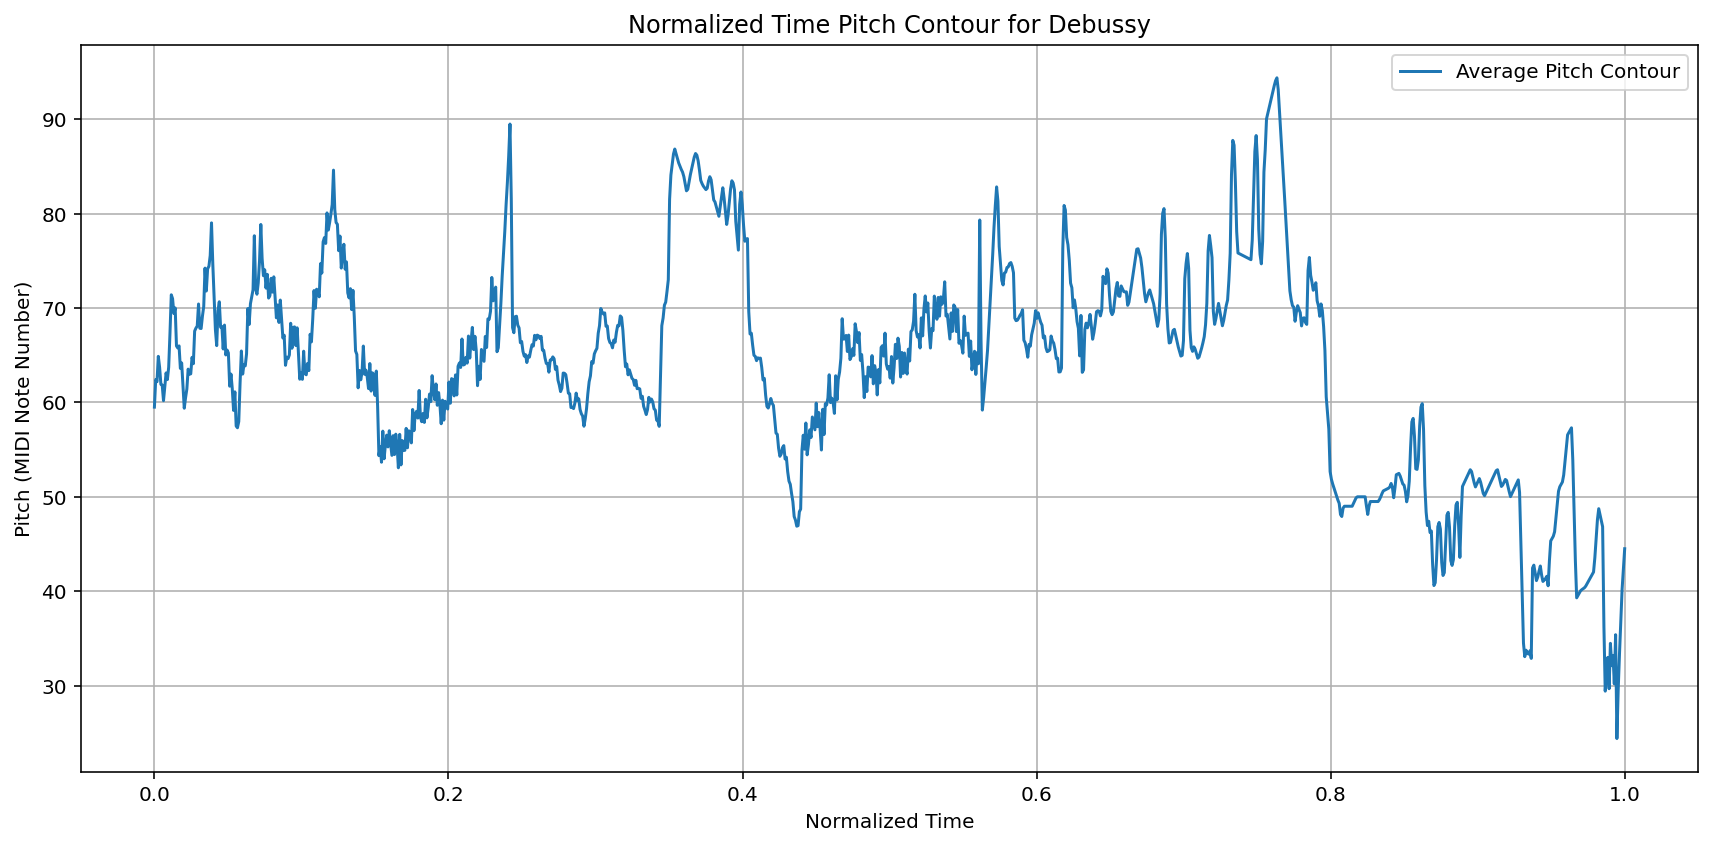

In [9]:
# 4. **Impressionist** (around1875-1925):
# Debussy: A pioneer of Impressionist music that emphasized timbre and bold harmonic innovation.

Impressionist_musician_paths = {
    'Debussy':'./Debussy/',
    }

for musician, path in Impressionist_musician_paths.items():
    music_data = read_musicxml_and_normalize(path)
    title = f"Normalized Time Pitch Contour for {musician}"
    # plot_pitch_contours(music_data, title)
    plot_average_pitch_contours(music_data, title)
    # plot_cdf(music_data, title)

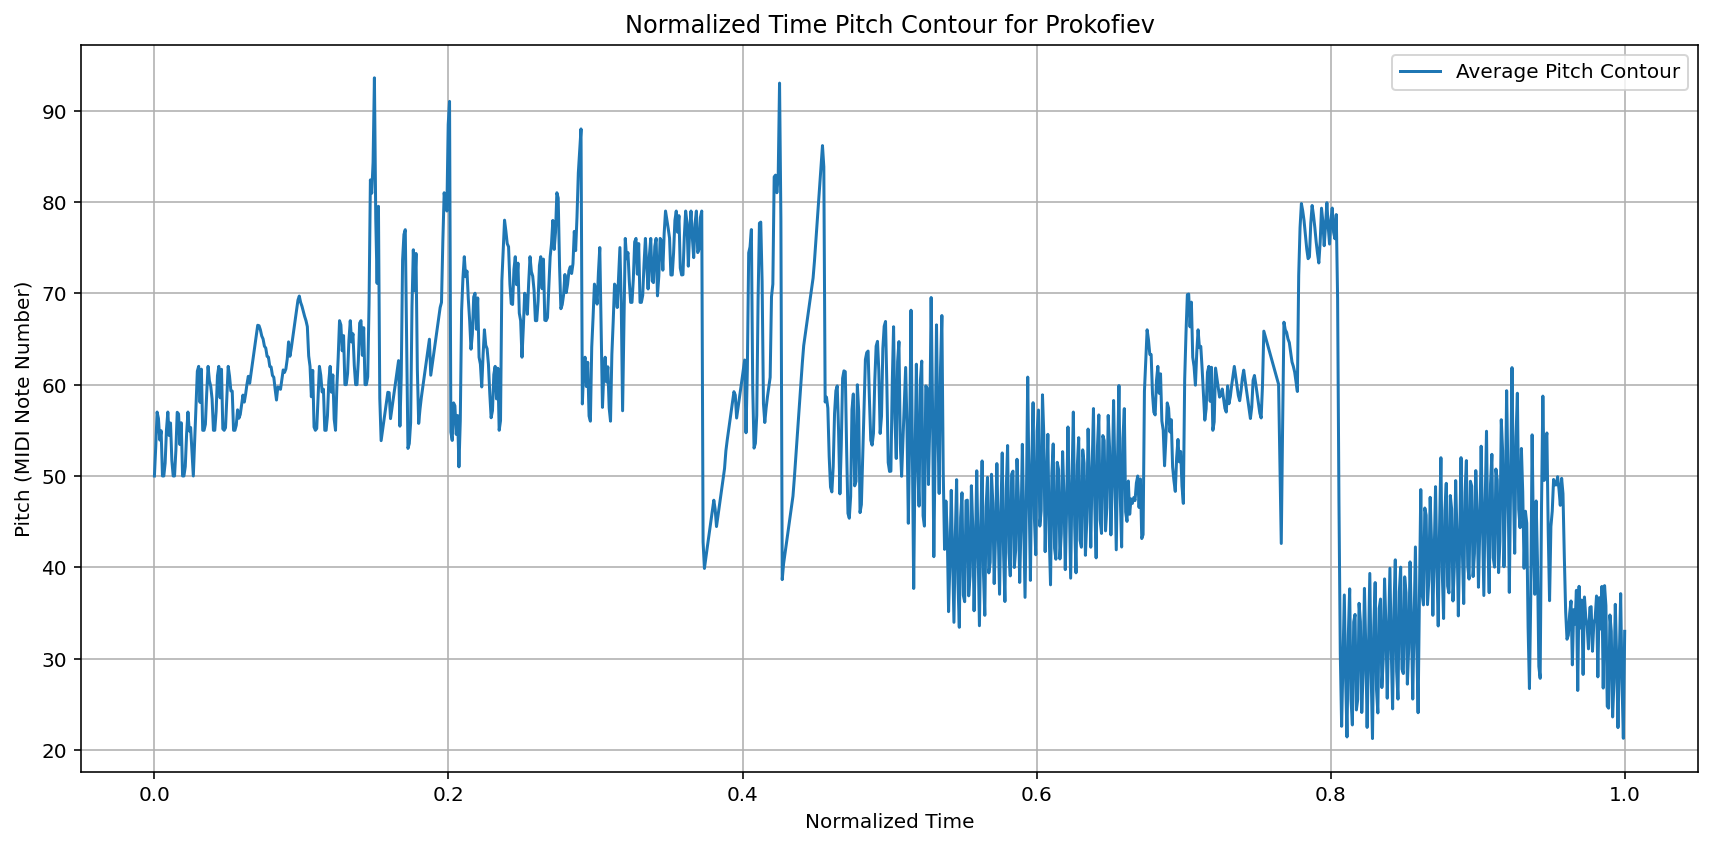

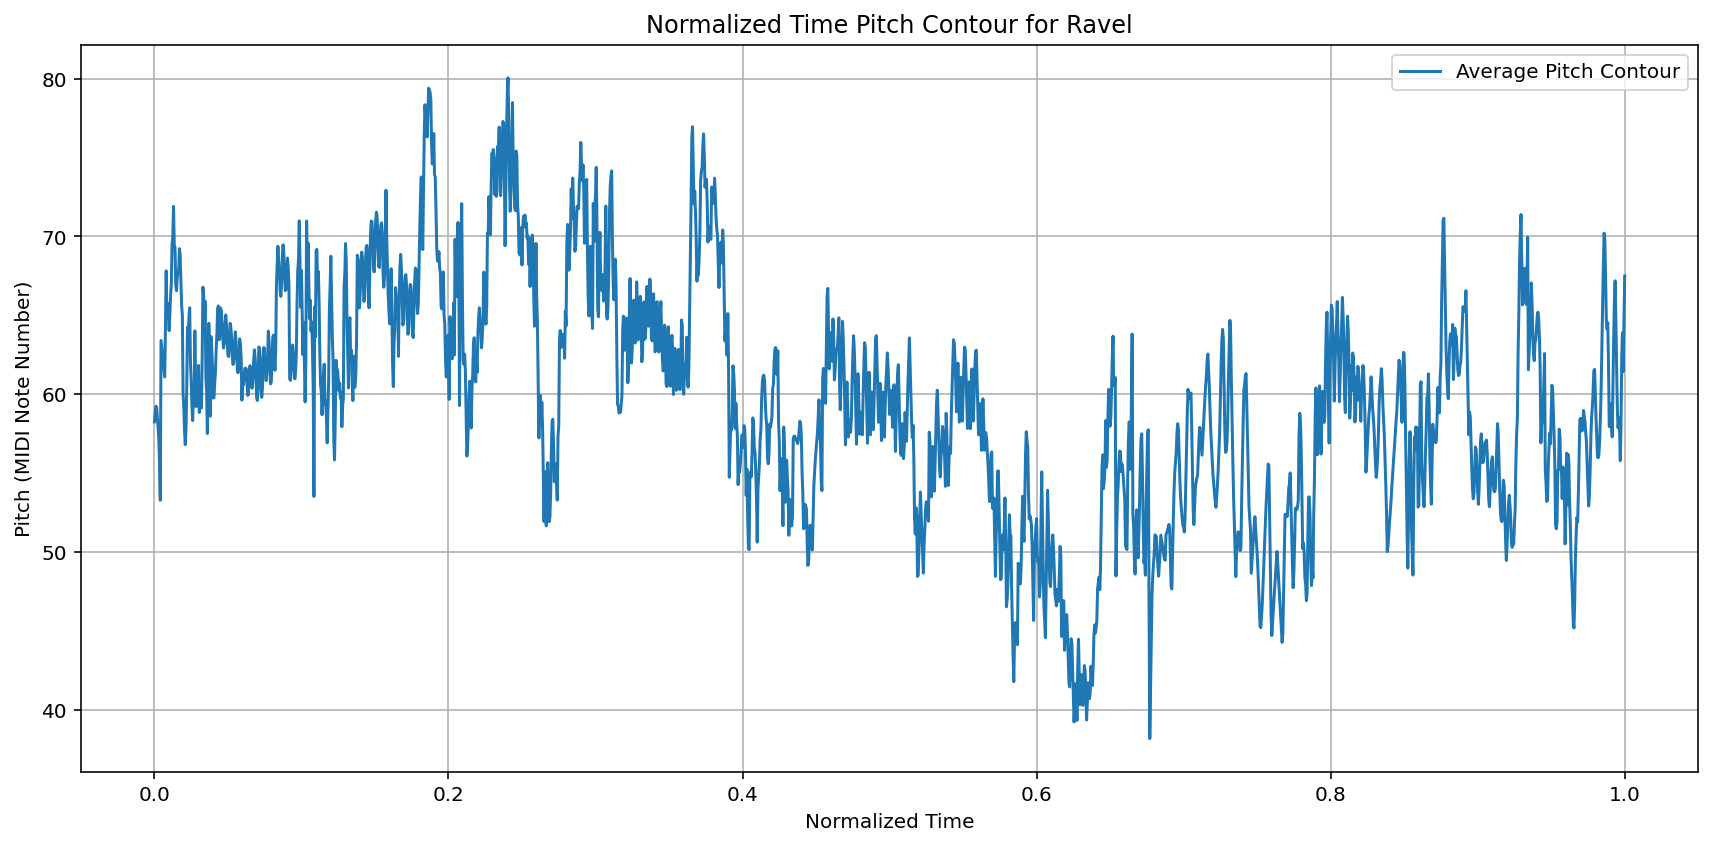

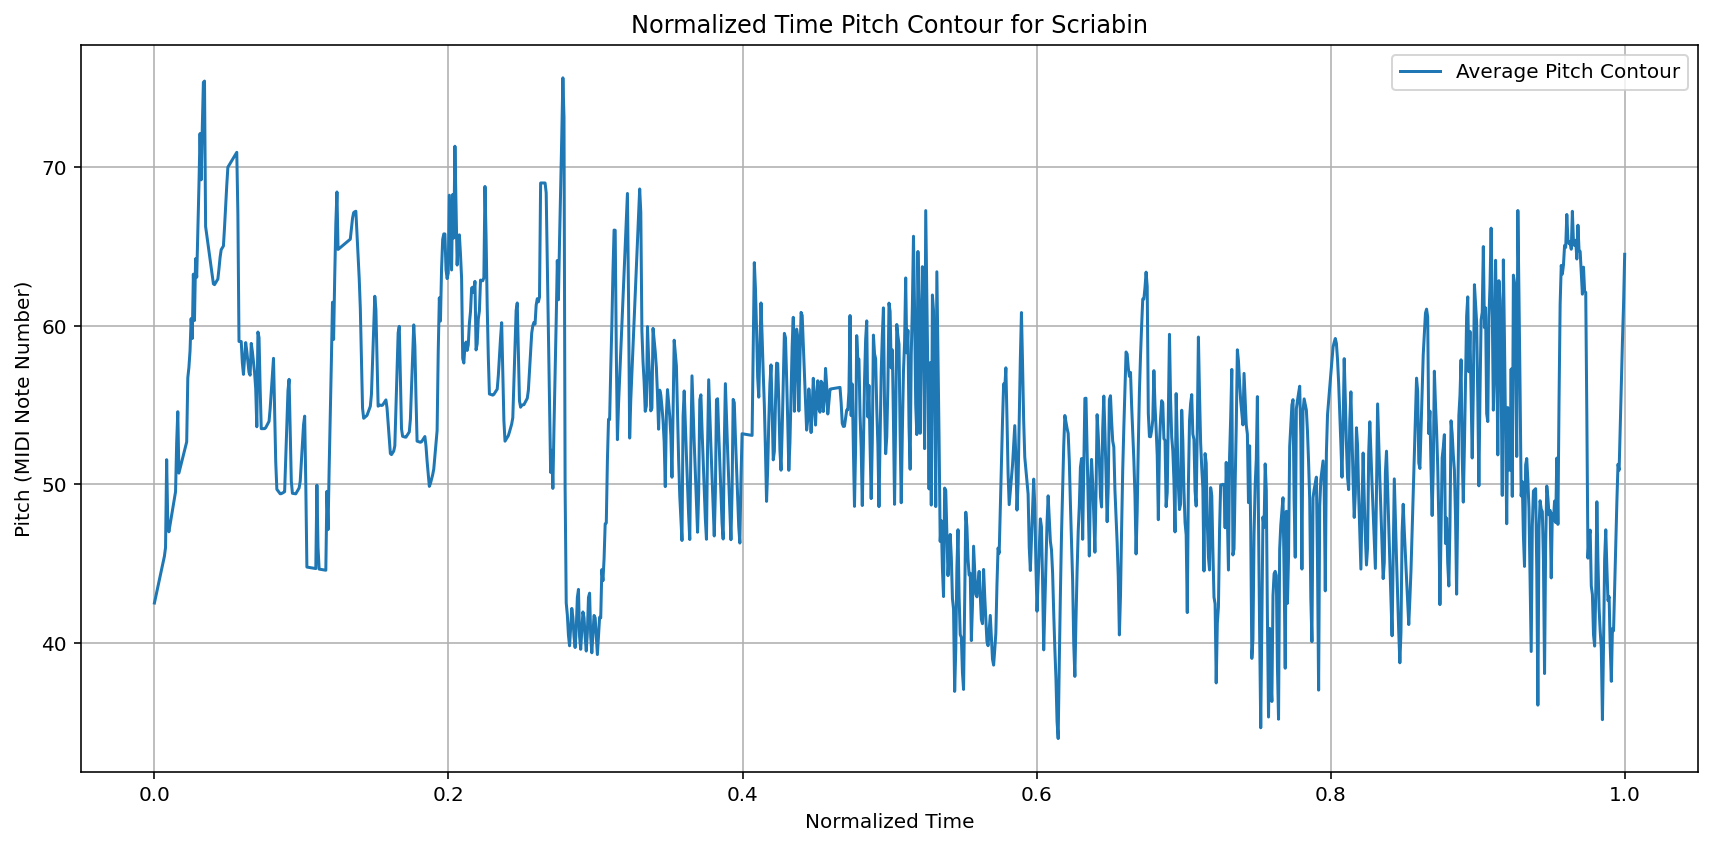

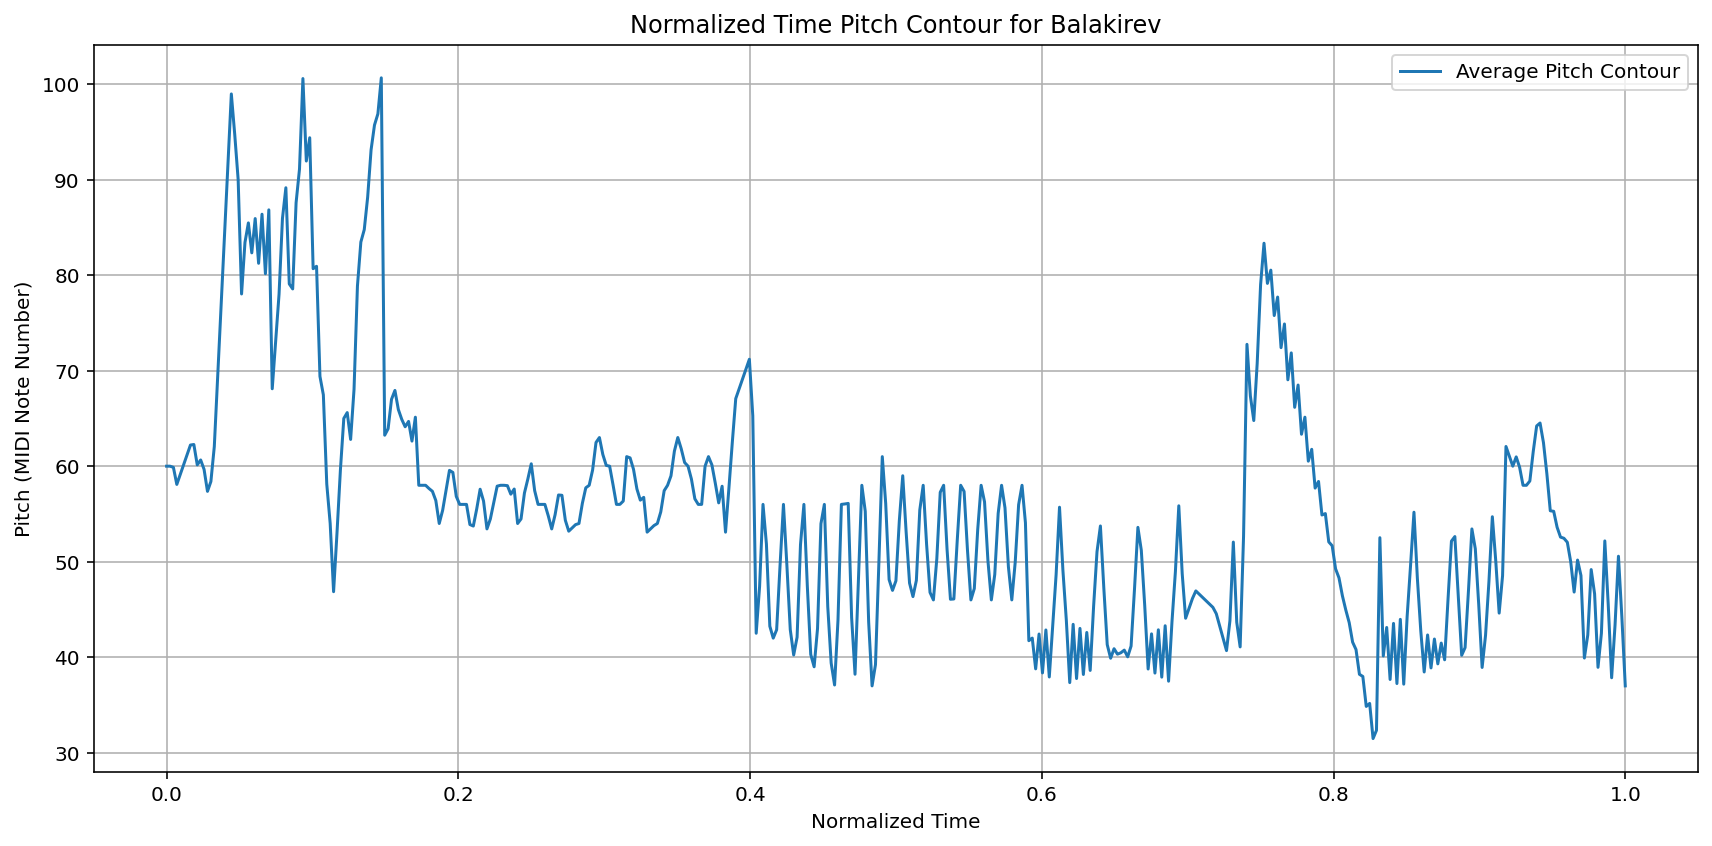

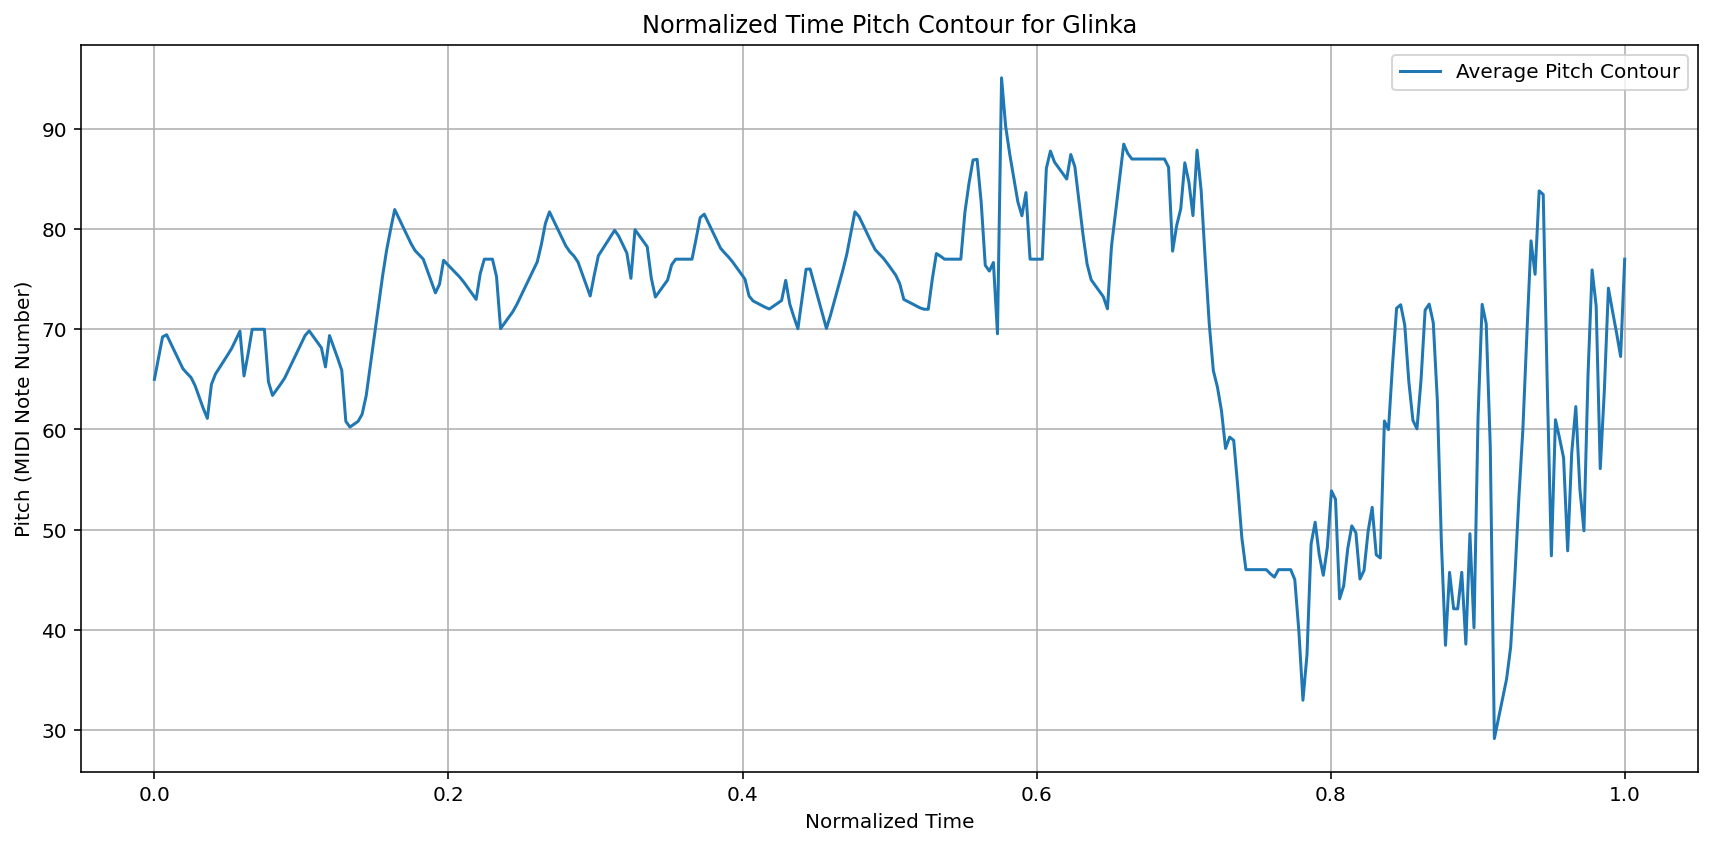

In [10]:
# 5. 20th century and modern music:
#  Prokofiev and Ravel: Their music often contains modernist features such as expanded harmonic and rhythmic complexity.
#  Scriabin: Innovative harmonic language and elements of mysticism.
#  Balakirev and Glinka : Important figure in Russian nationalist music.

Modern_musician_paths = {
    'Prokofiev':'./Prokofiev/',
    'Ravel':'./Ravel/',
    'Scriabin':'./Scriabin/',
    'Balakirev':'./Balakirev/',
    'Glinka':'./Glinka/',
    }

for musician, path in Modern_musician_paths.items():
    music_data = read_musicxml_and_normalize(path)
    title = f"Normalized Time Pitch Contour for {musician}"
    # plot_pitch_contours(music_data, title)
    plot_average_pitch_contours(music_data, title)
    # plot_cdf(music_data, title)

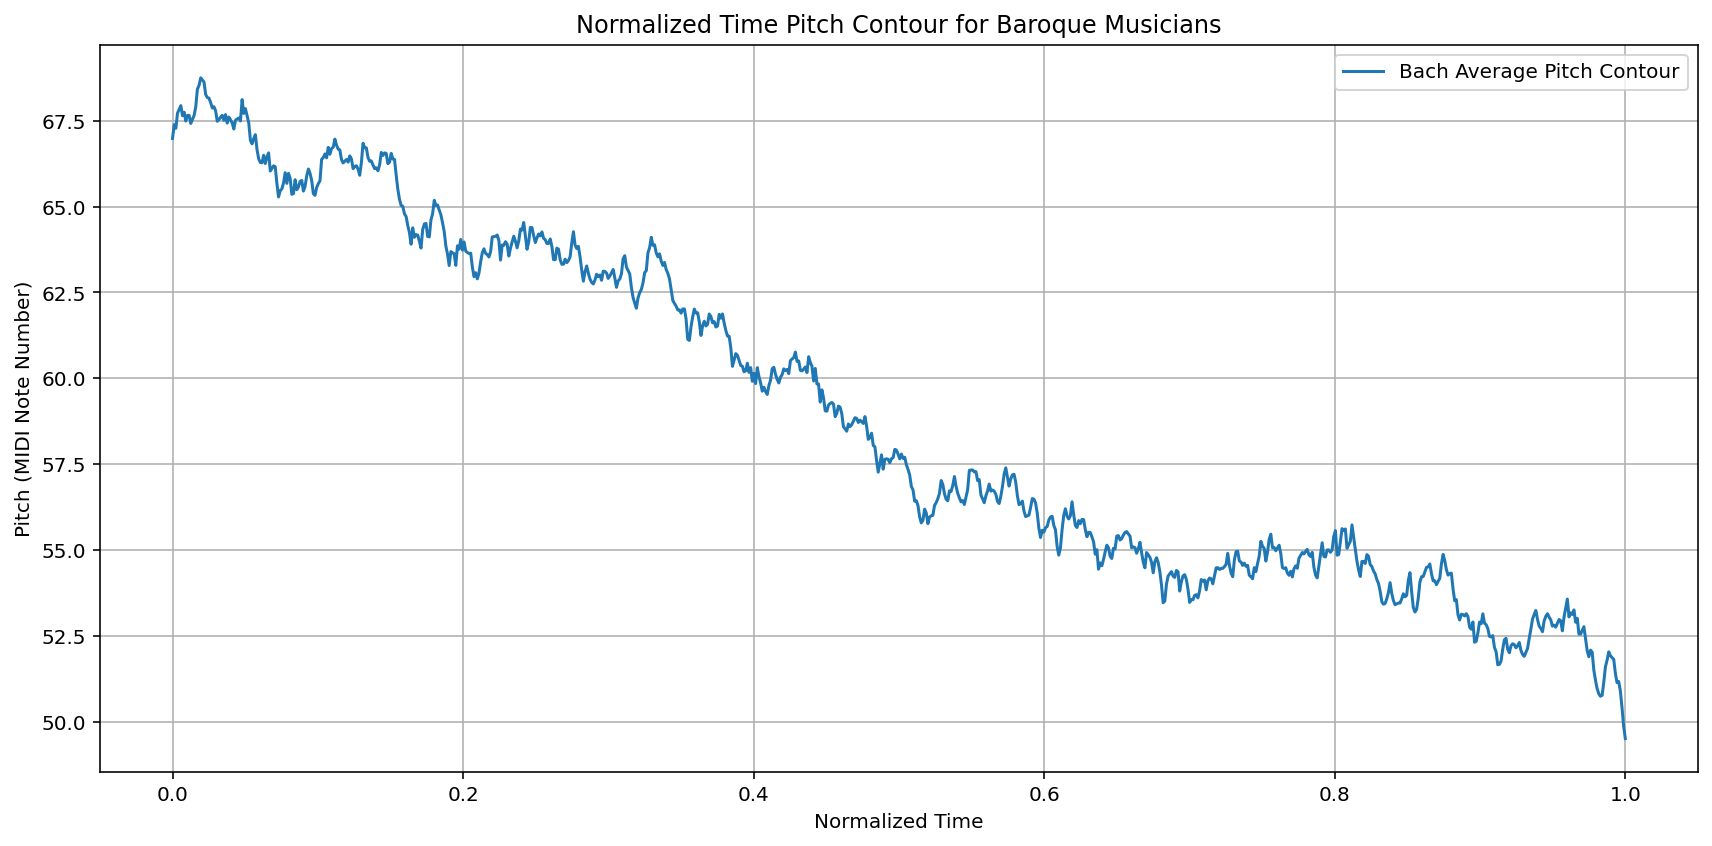

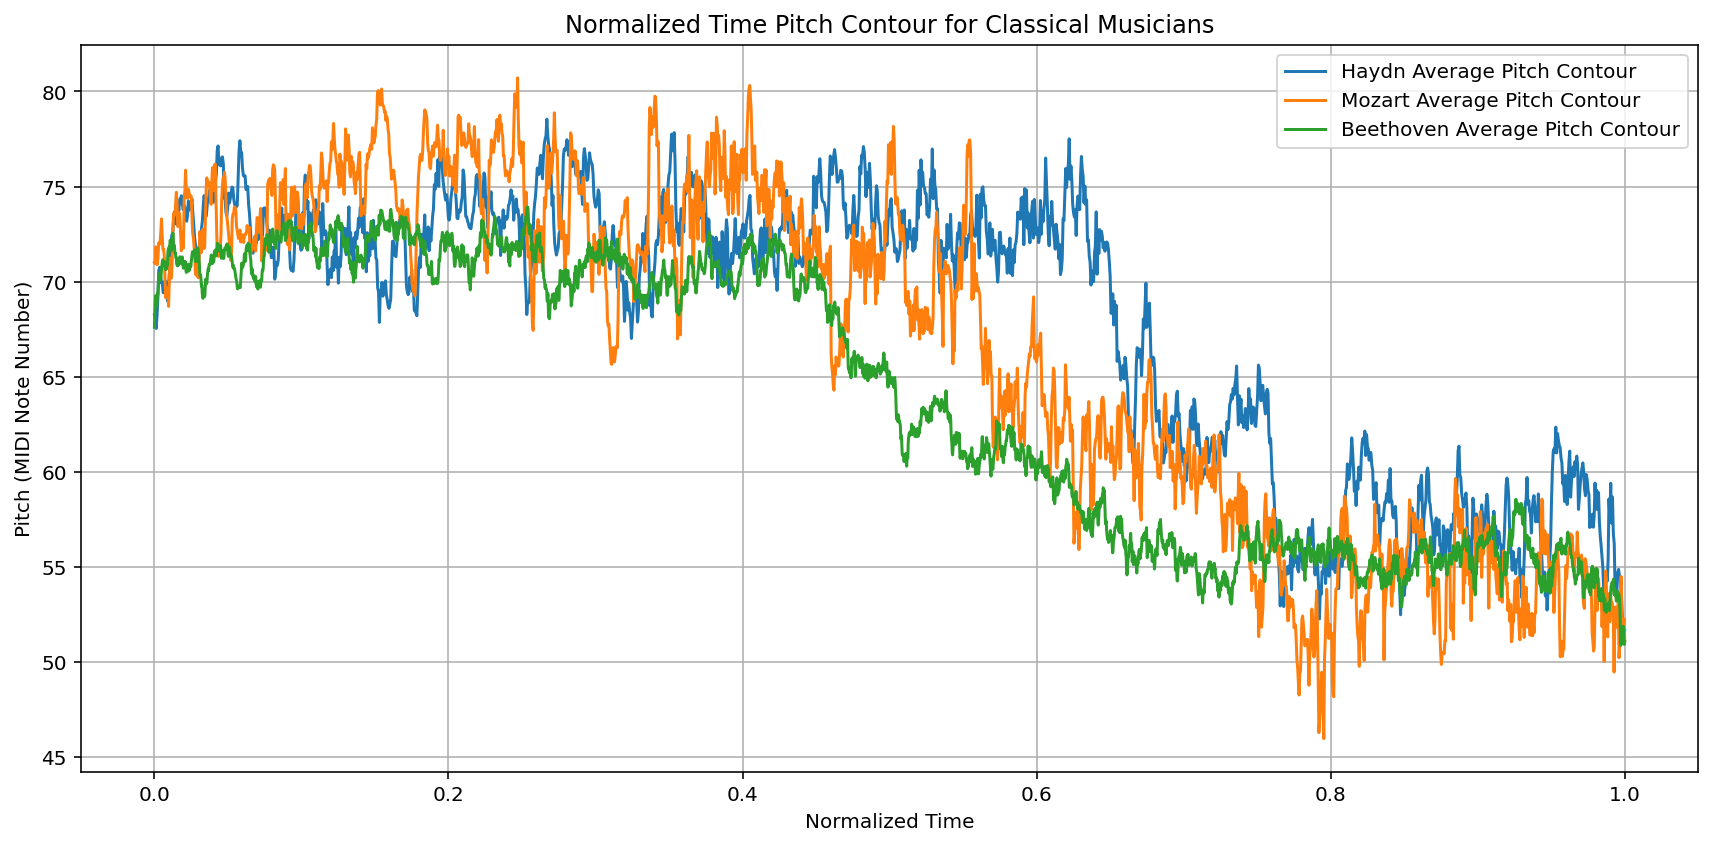

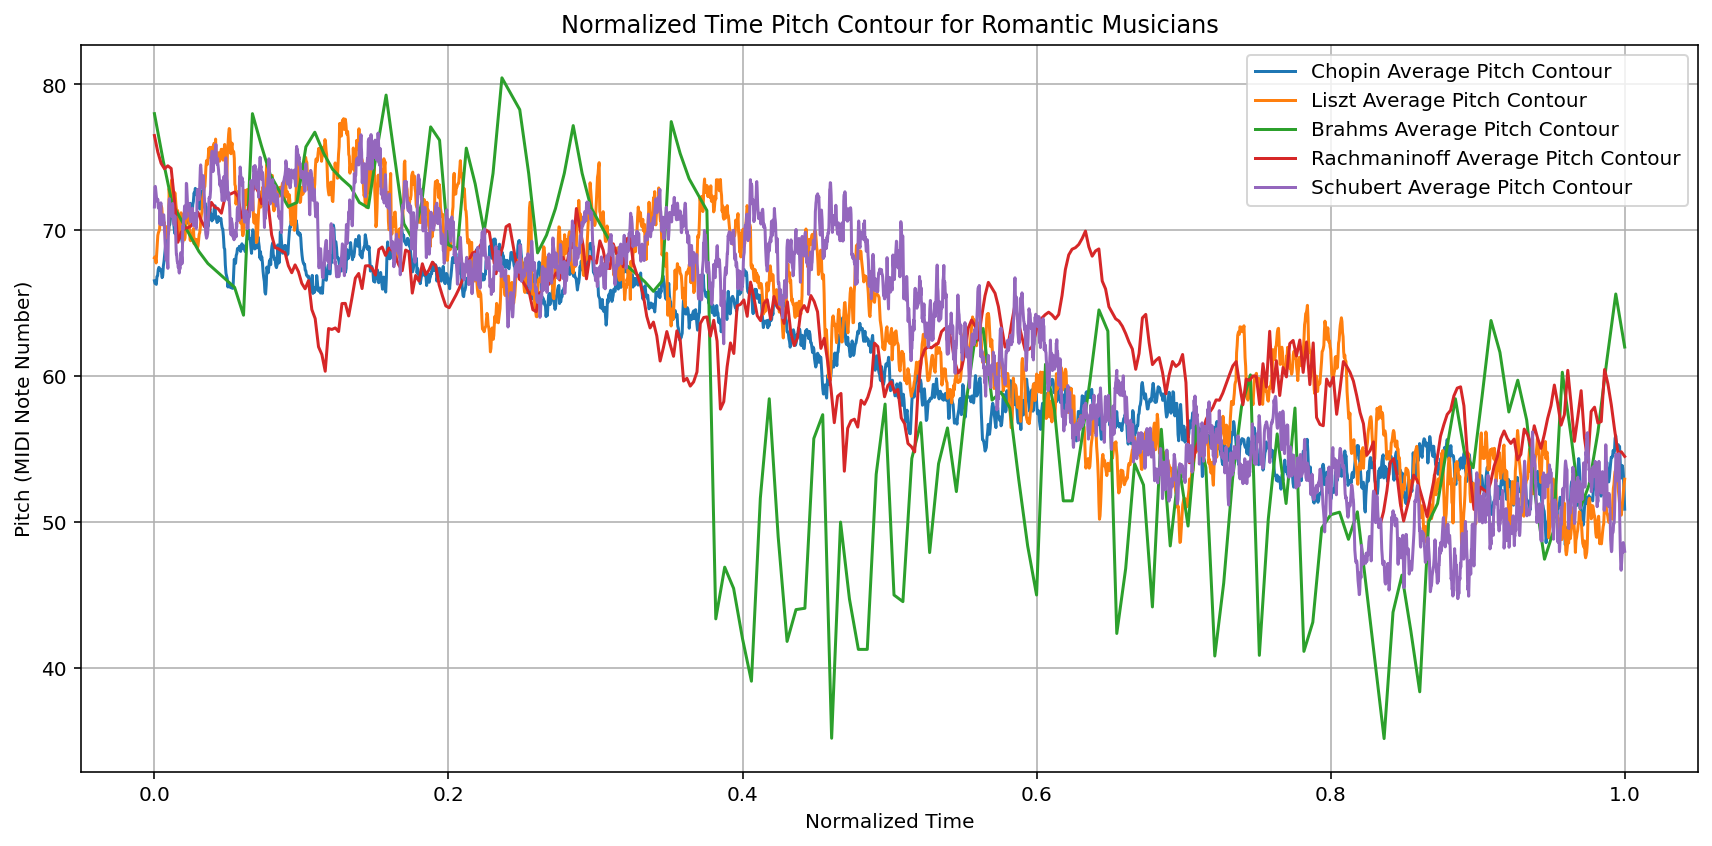

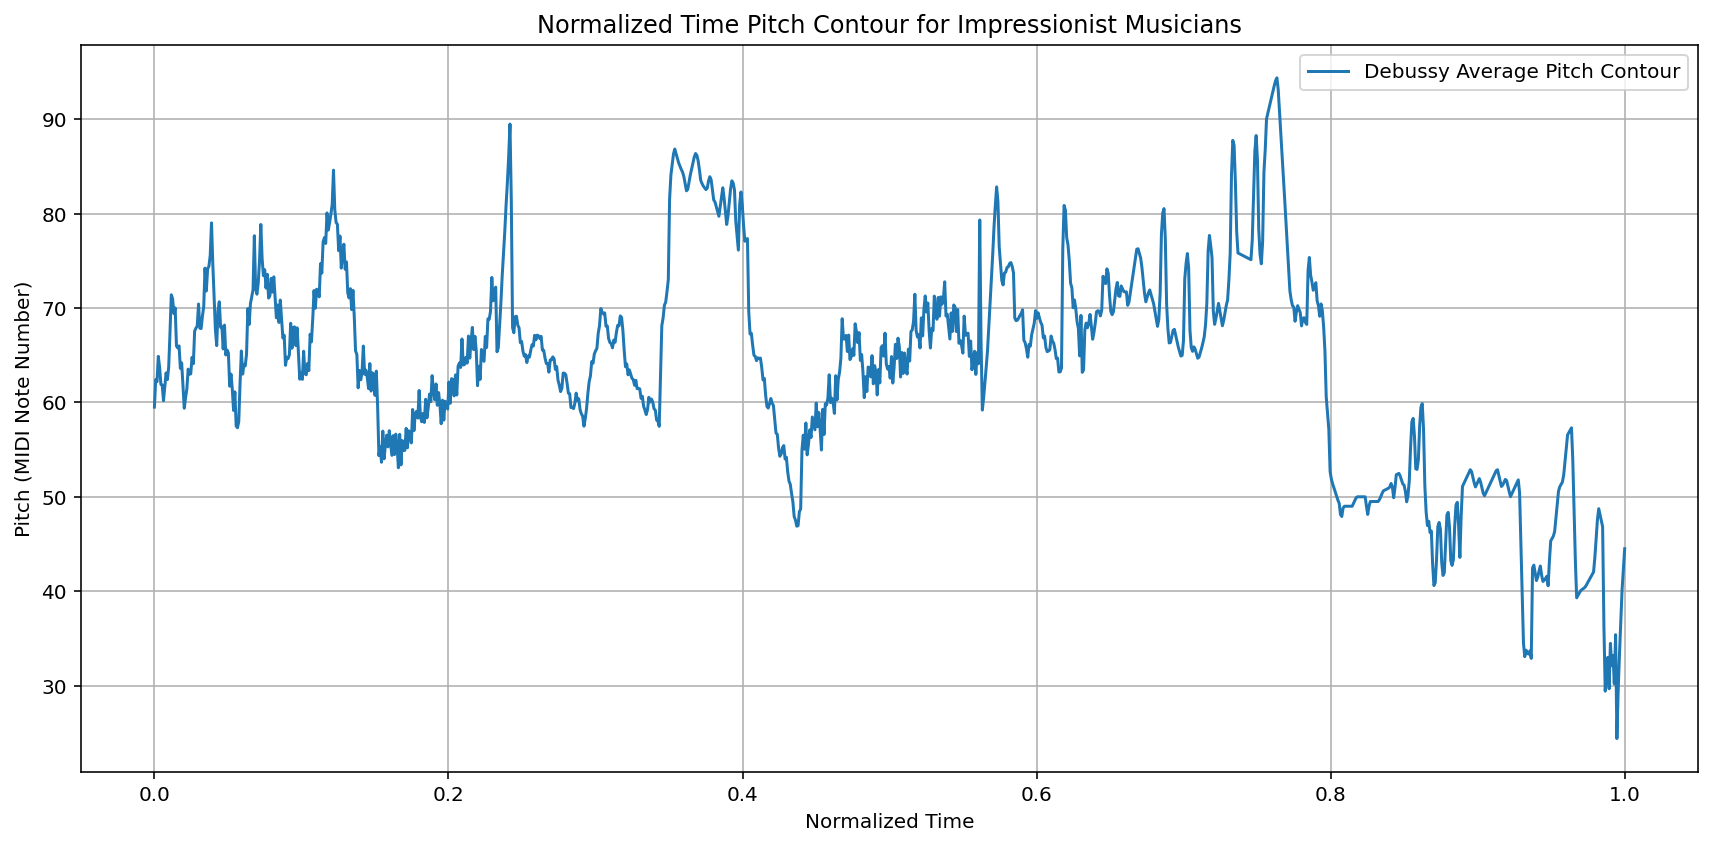

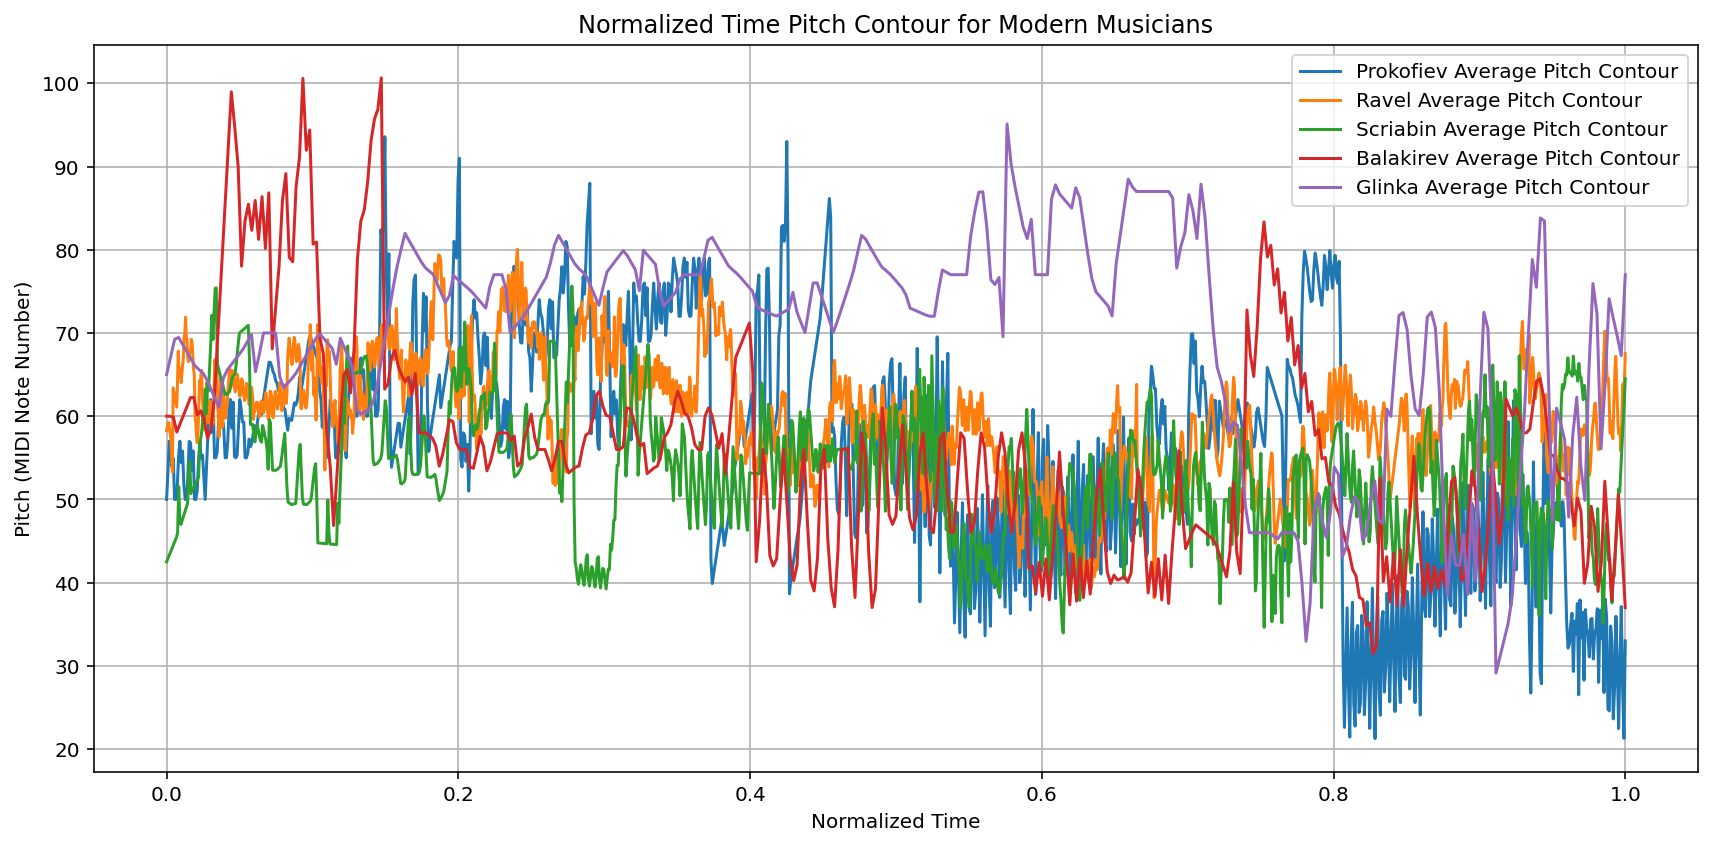

In [11]:
#  Draw an overall chart for each of the five periods
plot_musician_contours_for_era(Baroque_musician_paths, "Baroque")
plot_musician_contours_for_era(Classical_musician_paths, "Classical")
plot_musician_contours_for_era(Romantic_musician_paths, "Romantic")
plot_musician_contours_for_era(Impressionist_musician_paths, "Impressionist")
plot_musician_contours_for_era(Modern_musician_paths, "Modern")

In [12]:
# The tendency for pitches to go from high to low may be related to several musical theories and compositional practices:
# Musical form and structure: Many Western classical music works, especially longer works, often set a high-pitched theme at the beginning to attract the audience's attention. Subsequently, the concert gradually shifted to the mid-bass range to create a sense of ending, reflecting the overall "succession, transition, and integration" of the work.
# Melody tension and release: In classical music, melody is often constructed through tension in the high register and release in the mid-bass. This writing technique of starting on a high note and resolving to a lower range reflects the tension-relaxation principle common in Western music.
# Voice direction: According to Schenkerian analysis, many musical works follow a downward movement from treble to bass in deeper structure. This downward movement is regarded as the skeleton of music.
# Emotional trajectory of the piece: Many pieces follow a similar pattern in emotional expression, resulting in a melodic contour that rises and then falls, corresponding to the build-up and relief of emotional climaxes

In [13]:
# Quantitative analysis of different schools

In [14]:
# Information entropy analysis: 
# Calculate the entropy value of pitch distribution to evaluate the predictability and diversity of pitch content in musical works. 
# Low entropy values may indicate a more homogeneous use of pitches
# while high entropy values may indicate more diverse pitches.
from scipy.stats import entropy
def calculate_entropy(music_data):
    """
    Calculate the entropy of pitch distributions for each work or composer.
    Parameters:
    - music_data: A dictionary with keys representing different works or composers and values containing lists of pitches.
    Returns:
    - entropy values for each work or composer and average entropy.
    """
    entropy_results = {}
    entropy_values = []
    for key, data in music_data.items():
        pitch_counts = np.bincount(data['pitches'])
        entropy_results[key] = entropy(pitch_counts, base=2)
        entropy_values.append(entropy_results[key])
    # average entropy for all works
    average_entropy = np.mean(entropy_values) if entropy_values else None
    
    return entropy_values, average_entropy

In [15]:
# for every musician
for musician, path in Baroque_musician_paths.items():
    music_data = read_musicxml_and_normalize(path)
    entropy_results,average_entropy = calculate_entropy(music_data)
    print('Baroque_musicians -', musician, ":", average_entropy )

for musician, path in Classical_musician_paths.items():
    music_data = read_musicxml_and_normalize(path)
    entropy_results,average_entropy = calculate_entropy(music_data)
    print('Classical_musician -', musician, ":", average_entropy )

for musician, path in Romantic_musician_paths.items():
    music_data = read_musicxml_and_normalize(path)
    entropy_results,average_entropy = calculate_entropy(music_data)
    print('Romantic_musician -', musician, ":", average_entropy )

for musician, path in Impressionist_musician_paths.items():
    music_data = read_musicxml_and_normalize(path)
    entropy_results,average_entropy = calculate_entropy(music_data)
    print('Impressionist_musician -', musician, ":", average_entropy )

for musician, path in Modern_musician_paths.items():
    music_data = read_musicxml_and_normalize(path)
    entropy_results,average_entropy = calculate_entropy(music_data)
    print('Modern_musician -', musician, ":", average_entropy )

Baroque_musicians - Bach : 4.327673069077242
Classical_musician - Haydn : 4.851847305746056
Classical_musician - Mozart : 4.935668690782322
Classical_musician - Beethoven : 5.035490642025246
Romantic_musician - Chopin : 4.887793286699828
Romantic_musician - Liszt : 5.105725758044109
Romantic_musician - Brahms : 4.779974832070843
Romantic_musician - Rachmaninoff : 3.799512320652318
Romantic_musician - Schubert : 4.856803979851949
Impressionist_musician - Debussy : 5.027217495648207
Modern_musician - Prokofiev : 5.533239315404982
Modern_musician - Ravel : 5.096431665019554
Modern_musician - Scriabin : 5.044663931498461
Modern_musician - Balakirev : 4.828692927943339
Modern_musician - Glinka : 5.079302103803946


In [16]:
# for the whole period
all_musician_paths = {
    # Baroque
    'Bach': './Bach/',
    # Classical
    'Haydn': './Haydn/',
    'Mozart': './Mozart/',
    'Beethoven':'./Beethoven/',
    # Romantic
    'Chopin':'./Chopin/',
    'Liszt':'./Liszt/',
    'Schumann':'./Schumann/',
    'Brahms':'./Brahms',
    'Tchaikovsky':'./Tchaikovsky/',
    'Rachmaninoff':'./Rachmaninoff/',
    'Schubert':'./Schubert/',
    # Impressionist
    'Debussy':'./Debussy/',
    # Modern
    'Prokofiev':'./Prokofiev/',
    'Ravel':'./Ravel/',
    'Scriabin':'./Scriabin/',
    'Balakirev':'./Balakirev/',
    'Glinka':'./Glinka/',
}

# define the period
era_musician_paths = {
    'Baroque': ['Bach'],
    'Classical': ['Mozart', 'Haydn','Beethoven'],
    'Romantic': ['Chopin', 'Liszt','Schumann','Brahms','Tchaikovsky','Rachmaninoff','Schubert'],
    'Impressionist': ['Debussy'],
    'Modern': ['Prokofiev', 'Ravel', 'Scriabin','Balakirev','Glinka'],
}

# merge musician data for the same period
def merge_music_data_by_era(all_musician_paths, era_musician_paths):
    # create a new dic to conserve merged musical data
    merged_music_data_by_era = {}
    # traversal every period
    for era, musicians in era_musician_paths.items():
        # create a list to conserve the pitch data for all musicians in this period
        merged_pitches = []
        merged_times = []
        
       
        for musician in musicians:
            if musician in all_musician_paths:
                path = all_musician_paths[musician]
                music_data = read_musicxml_and_normalize(path)
                for work, data in music_data.items():
                    merged_pitches.extend(data['pitches'])
                    merged_times.extend(data['times'])
        
        merged_music_data_by_era[era] = {'pitches': merged_pitches, 'times': merged_times}
    
    return merged_music_data_by_era

In [17]:
# merge musician data(in the same period)
merged_music_data = merge_music_data_by_era(all_musician_paths, era_musician_paths)
print(merged_music_data.keys())

# check entropy for different period
for era, data in merged_music_data.items():
    pitch_counts = np.bincount(data['pitches'])
    entropy_value = entropy(pitch_counts, base=2)
    print("entropy of " , era , ":" , entropy_value)

dict_keys(['Baroque', 'Classical', 'Romantic', 'Impressionist', 'Modern'])
entropy of  Baroque : 5.312316589099355
entropy of  Classical : 5.709711483862927
entropy of  Romantic : 5.927381142786961
entropy of  Impressionist : 5.536442824312692
entropy of  Modern : 5.924016749133337


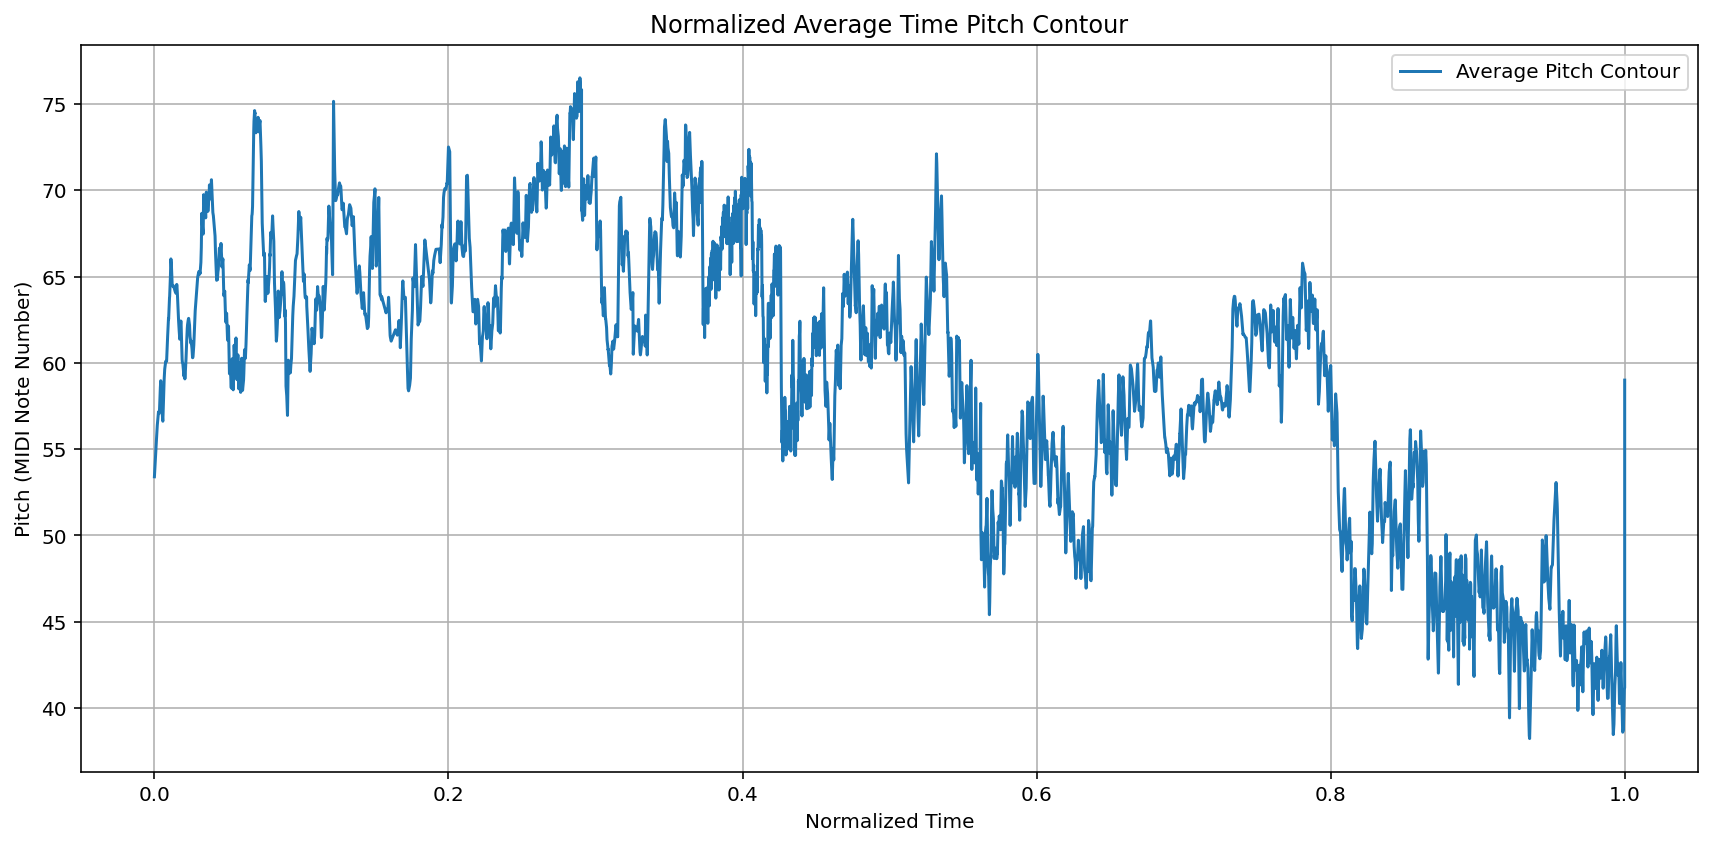

In [18]:
# visualize the trends for all periods, seems it's not obvious now
plot_average_pitch_contours(merged_music_data)

In [37]:
entropy,average_entropy = calculate_entropy(merged_music_data)
print(entropy)

[5.312316589099355, 5.709711483862927, 5.927381142786961, 5.536442824312692, 5.924016749133337]


In [21]:
# T-Test for the period
from scipy.stats import ttest_ind
def perform_t_test(music_data):
    """
    Perform t-tests to assess the significance of differences in pitch distributions between different works or composers.
    Parameters:
    - music_data: A dictionary with keys representing different works or composers
                  and values containing lists of pitches.
    Returns:
    - A dictionary with the t-test results, including t-values and p-values.
    """
    results = {}
    keys = list(music_data.keys())
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            t_stat, p_val = ttest_ind(music_data[keys[i]]['pitches'], music_data[keys[j]]['pitches'], equal_var=False)
            results[(keys[i], keys[j])] = {'t-statistic': t_stat, 'p-value': p_val}
    return results

In [23]:
t_test_results = perform_t_test(merged_music_data)
for key, value in t_test_results.items():
    print(key,value)

('Baroque', 'Classical') {'t-statistic': -53.82160400907966, 'p-value': 0.0}
('Baroque', 'Romantic') {'t-statistic': -50.674402453623905, 'p-value': 0.0}
('Baroque', 'Impressionist') {'t-statistic': -9.526887641253426, 'p-value': 6.059875167564001e-21}
('Baroque', 'Modern') {'t-statistic': -8.250350943205756, 'p-value': 1.7653659484390923e-16}
('Classical', 'Romantic') {'t-statistic': -1.4276821748180422, 'p-value': 0.15338553585704992}
('Classical', 'Impressionist') {'t-statistic': 3.3862999521453028, 'p-value': 0.0007272962884586388}
('Classical', 'Modern') {'t-statistic': 16.21263088436728, 'p-value': 2.7879477273992842e-58}
('Romantic', 'Impressionist') {'t-statistic': 3.659086253294932, 'p-value': 0.0002619646199782498}
('Romantic', 'Modern') {'t-statistic': 16.45759282952175, 'p-value': 4.894776677640013e-60}
('Impressionist', 'Modern') {'t-statistic': 4.589198945049557, 'p-value': 4.697224108904339e-06}


### The table based on the test results

| Group 1        | Group 2        | t-statistic       | p-value           |
|----------------|----------------|-------------------|-------------------|
| Baroque        | Classical      | -53.821604        | 0.0               |
| Baroque        | Romantic       | -50.674402        | 0.0               |
| Baroque        | Impressionist  | -9.526888         | 6.06e-21          |
| Baroque        | Modern         | -8.250351         | 1.77e-16          |
| Classical      | Romantic       | -1.427682         | **0.153**         |
| Classical      | Impressionist  | 3.386300          | 0.000727          |
| Classical      | Modern         | 16.212631         | 2.79e-58          |
| Romantic       | Impressionist  | 3.659086          | 0.000262          |
| Romantic       | Modern         | 16.457593         | 4.89e-60          |
| Impressionist  | Modern         | 4.589199          | 4.70e-06          |

### T-Statistic Matrix

|               | Baroque     | Classical  | Impressionist | Modern     | Romantic   |
|---------------|-------------|------------|---------------|------------|------------|
| **Baroque**       | 0.00        | -53.82     | -9.53         | -8.25      | -50.67     |
| **Classical**     | -53.82      | 0.00       | 3.39          | 16.21      | -1.43      |
| **Impressionist** | -9.53       | 3.39       | 0.00          | 4.59       | 3.66       |
| **Modern**        | -8.25       | 16.21      | 4.59          | 0.00       | 16.46      |
| **Romantic**      | -50.67      | -1.43      | 3.66          | 16.46      | 0.00       |

### P-Value Matrix

|               | Baroque     | Classical   | Impressionist | Modern        | Romantic     |
|---------------|-------------|-------------|---------------|---------------|--------------|
| **Baroque**       | 1.00        | 0.00        | 6.06e-21      | 1.77e-16      | 0.00         |
| **Classical**     | 0.00        | 1.00        | 7.27e-04      | 2.79e-58      | 1.53e-01     |
| **Impressionist** | 6.06e-21    | 7.27e-04    | 1.00          | 4.70e-06      | 2.62e-04     |
| **Modern**        | 1.77e-16    | 2.79e-58    | 4.70e-06      | 1.00          | 4.89e-60     |
| **Romantic**      | 0.00        | 1.53e-01    | 2.62e-04      | 4.89e-60      | 1.00         |